In [75]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML, Image
import nbconvert
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import sys
sys.path.insert(0, '../src/visualization')
import visualize 
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

<h2 align="center">DSC180A, Section B04: Genetics</h2>
<h2 align="center">Saroop Samra, Justin Kang</h2>

## Background

This study’s main objective is to find gene expression differences among individuals that were diagnosed with one of three psychiatric disorders: schizophrenia, bipolar disorder, or major depressive disorder[<sup>1</sup>](#fn1). The study uses RNA-Sequencing on brain tissue from samples taken from three regions of the brain: anterior cingulate cortext (AnCg), dorsolateral prefrontal cortex (DLPFC), and the nucleaus accumbens (nAcc), which are commonly associated with cognitive behaviors. The goal is then to observe whether or not there exists overlapping genes across the three disorders. Schizophrenia, bipolar disorder, and major depressive disorder share many phenotypic characteristics like psychosis and cognitive deficits among individuals but evidence for such similarities have yet to be found through genomic methods. If evidence of overlapping genes amongst the three disorders can be found, then it would significantly impact our current knowledge of the disorders.

Bipolar disorder, schizophrenia, and major depressive disorders have been associated with high rates of suicide, thus any additional knowledge about the underlying disorders are sought after for good reason[<sup>1</sup>](#fn1). With the possibility of common underlying genes between the three disorders, future research can not only better understand but also ideally classify and predict the disorders early on. The findings are extremely impactful as they may help in two ways: firstly to help predict and diagnose patients and secondly to help potentially cure or alleviate the impact of the disorder. Current treatment methods only cover some of the symptoms expressed in the disorders, thus making them an incomplete solution to an extraneous problem.

## Psychiatric Disorders

### Schizophrenia

Schizophrenia is classified as a serious mental illness that can affect an individual's cognitive behaviors affecting how one thinks, feels, and subsequently behaves[<sup>2</sup>](#fn2). Typically diagnosed in the late teen years to early thirties of individuals, schizophrenia can be diagnosed in both males and females, but appears earlier in males. This illness invokes a sense of disconnection between reality for individuals diagnosed and symptoms can be diagnosed into three categories: psychotic symptoms, negative symptoms, and cognitive symptoms[<sup>2</sup>](#fn2). Psychotic symptoms generally create an altered perception of the real world through hallucinations and delusions that result in a lost sense of reality. Negative symptoms focus more on a lack of motivation by the individual which could lead to disinterests in social activities as well as difficulty showing both emotions and functioning normally. Individuals with cognitive symptoms experience issues with attention and memory which leads to difficulties in remembering and processing information. Risk factors for schizophrenia include genetics, the environment, and both the structure and function of the brain[<sup>2</sup>](#fn2). Although there is not a complete cure for schizophrenia, current treatment methods such as antipsychotic medications and psychosocial treatments help manage the disorder.


### Bipolar Disorder

Bipolar disorder can be categorized into three types: Bipolar I Disorder, Bipolar II Disorder, and Cyclothymic Disorder, and they are all involved in the changes in mood, energy, and activity levels of diagnosed individuals[<sup>3</sup>](#fn3). The disorder is generally diagnosed during an individual's late teen years or early adulthood, but cases have been seen with children as well as with pregnant women after giving birth. Diagnosed individuals experience what are called “mood episodes” where they will display immense emotions that range from extreme thrill to moody, or animate to hopeless[<sup>3</sup>](#fn3). Uncharacteristic behavior as well as the inability to be aware of their actions are also common symptoms. There have not been clear findings as to the exact risk factors associated with bipolar disorder, but current research suggests that the environment and structure and function of the brain play an impactful role[<sup>3</sup>](#fn3). Treatment for this disorder includes medication in the form of mood stabilizers and atypical antipsychotics as well as psychotherapy or “talk therapy”. This disorder requires lifelong treatement, as symptoms can appear over time with periods free of episodes.

### Major Depressive Disorder

Major Depressive Disorder shares some commonality with bipolar disorders but is considered its own distinct mood disorder. Generally diagnosed at the beginning of adulthood[<sup>4</sup>](#fn4), there are multiple forms of depression like postpartum depression and psychotic depression, but all generally affect how a diagnosed individual behaves and operates in their daily lives. Several symptoms of depression exist and include persistent sadness, irritability, decreased energy or fatigue, and difficulty sleeping regularly. In order to be correctly diagnosed with depression, however, the individual must be experiencing symptoms nearly every day for at least two weeks[<sup>4</sup>](#fn4). Risk factors associated with this disorder include genetics, biological, environmental, psychological, or a combination of the four. Despite its serious nature, depression can be treated effectively and even more so if treated early. Treatment can come in the form of medication, through antidepressants, and psychotherapies, with electroconvulsive therapy being an alternative in the case traditional medications are ineffective[<sup>4</sup>](#fn4).

## RNA Sequencing

This study uses RNA-Sequencing on tissue samples across three areas of the brain: the anterior cingulate cortex (AnCg), the dorsolateral prefrontal cortex (DLPFC), and the nucleus accumbens (nAcc). Each of these regions is connected to cognitive behaviors such as mood alterations and impulse, which are typically altered with any one of the three psychiatric disorders[<sup>1</sup>](#fn1). From this, the study aims to provide a high confidence set of genes whose expression associated with these disorders.

There are 24 samples for each of the three disorders as well as a control group, from which our samples are drawn. RNA-Sequencing is an advantageous tool that allows the transcriptome of a gene expression to be surveyed in a very high-throughput and quantitative manner[<sup>5</sup>](#fn5). It is important to understand the transcriptomes as they provide information regarding the functional elements of a genome as well as the transcriptional structure of the gene. This study places significance on the varying gene expression levels between the three psychiatric disorders and therefore would also need the accurate quantification of such levels that RNA-Sequencing provides.



## Pipeline

For this project, we will need to take the two pair-ended .fastq files per patient sample and run a quality check fastqc[<sup>7</sup>](#fn7) on them. Then we use cutadapt[<sup>6</sup>](#fn6) which removes adaptors in order to clean the data (after this we run the quality check again). By doing a quality before and afterwards we can evaluate the effectiveness of the cleaning step. The cleaned data pair will then be transformed by running the align count step, which has two options:

1. kallisto - this is a faster tool and we plan to use. It takes roughly 10 minutes to process a pair with 8 bootstrap samples. The output will be a gene count table for each SRA run.

2. STAR - generate alignments and gene count and we will maintain these as a single file per patient. STAR optionally can output BAM files which are binary sequence alignment files which we do an additional quality check using picard after manual quality checks have confirmed the quality.

The next step is to execute the "merge" step: which takes all the gene count SRA files and merges them in one gene matrix table using Pandas[<sup>14</sup>](#fn14). The output will also be a gene experiments table which identifies the sample labels and the patient features (age, disorder etc). 

After merging, we execute the "normalize" step: this imports the merged gene count matrix into a custom R script which uses the DESeq2[<sup>15</sup>](#fn15) module to generate two normalized matrix counts: one uses standard normalization and the other Variable Stablization Transformation.

After normalizing we execute the "analysis" step: this generates 9 Likelihood Ratio test (LRT), a hypothesis test that compares models in terms of how they fit the available data by comparing the likelihood scores of the models[<sup>9</sup>](#fn9). Each of the 9 LRT's corresponds to a one brain region and one disorder. The LRT will be compared against that disorder versus the control group. Additionally, an MA Plot and Heatmap are generated.

The overall pipeline is shown in Figure 1 below.

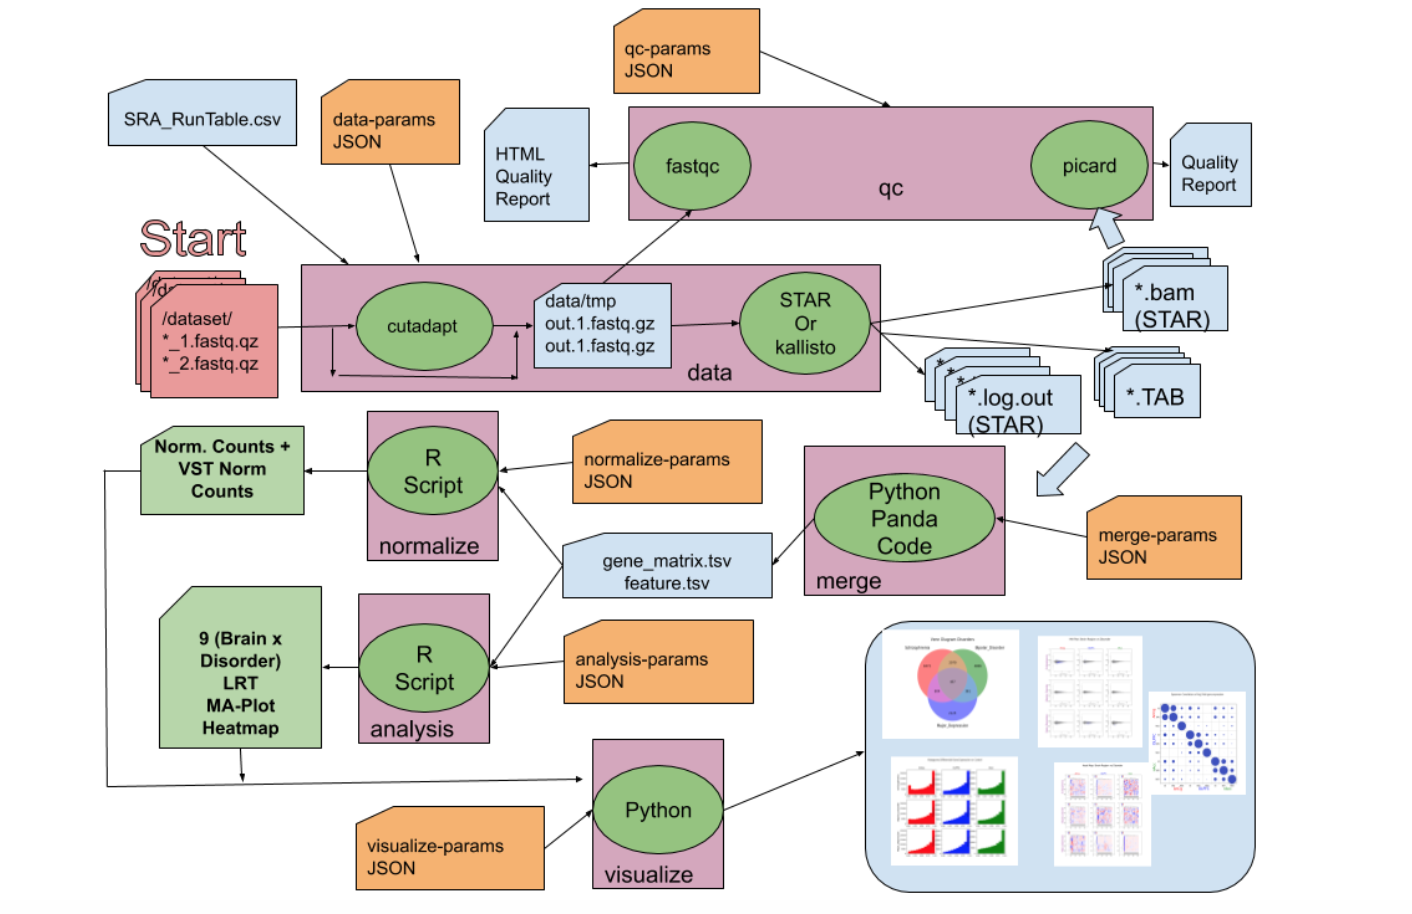

In [2]:
Image("pipeline.png", width=800)

Figure 1: Our Pipeline

Apart from the fastq files there is also an SRA Run table as an input to the pipeline which is shown below in Table 1.

In [43]:
df = pd.read_csv("../data/raw/SraRunTable.csv")
df[["Run", "age_at_death", "Brain_pH", "post-mortem_interval", "brain_region", "clinical_diagnosis"]]

,Run,age_at_death,Brain_pH,post-mortem_interval,brain_region,clinical_diagnosis
0,SRR3438555,40,6.76,12.25,AnCg,Control
1,SRR3438556,58,6.93,24.00,AnCg,Control
...,...,...,...,...,...,...
17,SRR3438572,69,6.91,11.25,AnCg,Major Depression
18,SRR3438573,48,6.95,37.00,AnCg,Major Depression


Table 1: The SRA Run Table subset acted as our main source for the project, especially when it came to the exploratory data analysis portion of the project. Each row represents a different sample of the brain from a patient diagnosed with one of the three brain disorders or as the control. The information in the table include the patients age at death, their brain ph levels, the post-mortem interval, the brain region, and the diagnosed disorder. 

## Quality Checks

#### Cutadapt

Cutadapt is a tool that primarily focuses on removing adapter sequences that happen to be attached to DNA and RNA molecules during sequencing procedures[<sup>6</sup>](#fn6). These adapters are included during the sequencing process as a result of the length of the molecules sequenced being shorter than what most current sequencers can manage. By locating and removing adapter sequences, cutadapt ensures that only relevant information about a molecule is being analyzed. Implementation of cutadapt contributes to our project in the form of ensuring that our data contains only the relevant information we need in order to perform our analysis and subsequently reproduce this experiment. Cutadapt's versatility in terms of what it can do is another reason to advocate for its use. Unlike similar programs, cutadapt not only removes adapters, it can also search for multiple adapters, search and remove adapters multiple times, and trim adapter sequences[<sup>6</sup>](#fn6). 

#### FastQC

FastQC is another tool that assists in checking the quality of our data prior to any serious analysis. The software takes in our fastq.qz files and outputs a series of analysis summaries that check the quality on the raw sequence data used as part of our sequencing pipeline process[<sup>7</sup>](#fn7). Some of the analysis given as an output include per base sequency quality, which shows the quality of each base at each position, a quality score for each sequence, which isolates quality scores for a subset of sequences, and the contents contained in each sequence[<sup>7</sup>](#fn7). These analyses from FastQC provide an insight into our data and allow us to determine the impact the quality of our data can have when it comes to our own analysis. For the purposes of this project, FastQC is used to check the quality of our data without any alterations and the used again to check our data that has gone through modifications. Specifically, these modifications come in the form of cutadapt. By being able to compare the outputs of the two FastQC reports, we can then be able to make a determination as to whether or not steps, such as cutadapt, need to be applied in our pipeline.

#### Data Specificity

We ran FastQC as it gave us the ability to measure the quality of our raw data. Cutadapt was another tool available that allowed us to check for imperfections in our data, specifically adapter sequences. We originally sought to compare the quality reports provided by FastQC on our raw sequencing data and on our data after cutadapt was applied. The intention being, by running an extra cleaning step in our pipeline we can ensure our data is at the optimal level in terms of quality. However, discussions with other students about how the impact cutadapt had on our data led to us to test whether or not cutadapt was something we really needed for this project.

For our test, we took one random sample of a patient diagnosed with schizophrenia for each brain region from our SraRunTable.csv. We chose schizophrenia patients due to their significance from the original replication paper when it came to the observed data generated specifically from these patients. For each sample, we ran FastQC twice. The first run consisted of the sample without cutadapt applied and the second run with cutadapt applied. In terms of the specific analysis we wanted to use to compare our results, we focused on six of the twelve reports available as part of a FastQX report: Per Base Quality, Per Sequence Quality, Per Base Sequence Context, Per Sequence GC Content, Overrepresented Sequences, and Adapter Content. Other analyses such as Per Title Sequence Quality and Sequence Length Distribution were ignored due to their irrelevance in terms of how the existence of an adapter sequence impacts the overall quality of the data. Figure 2 below shows the Per Base Quality analysis for three separate samples across the three different brain regions.






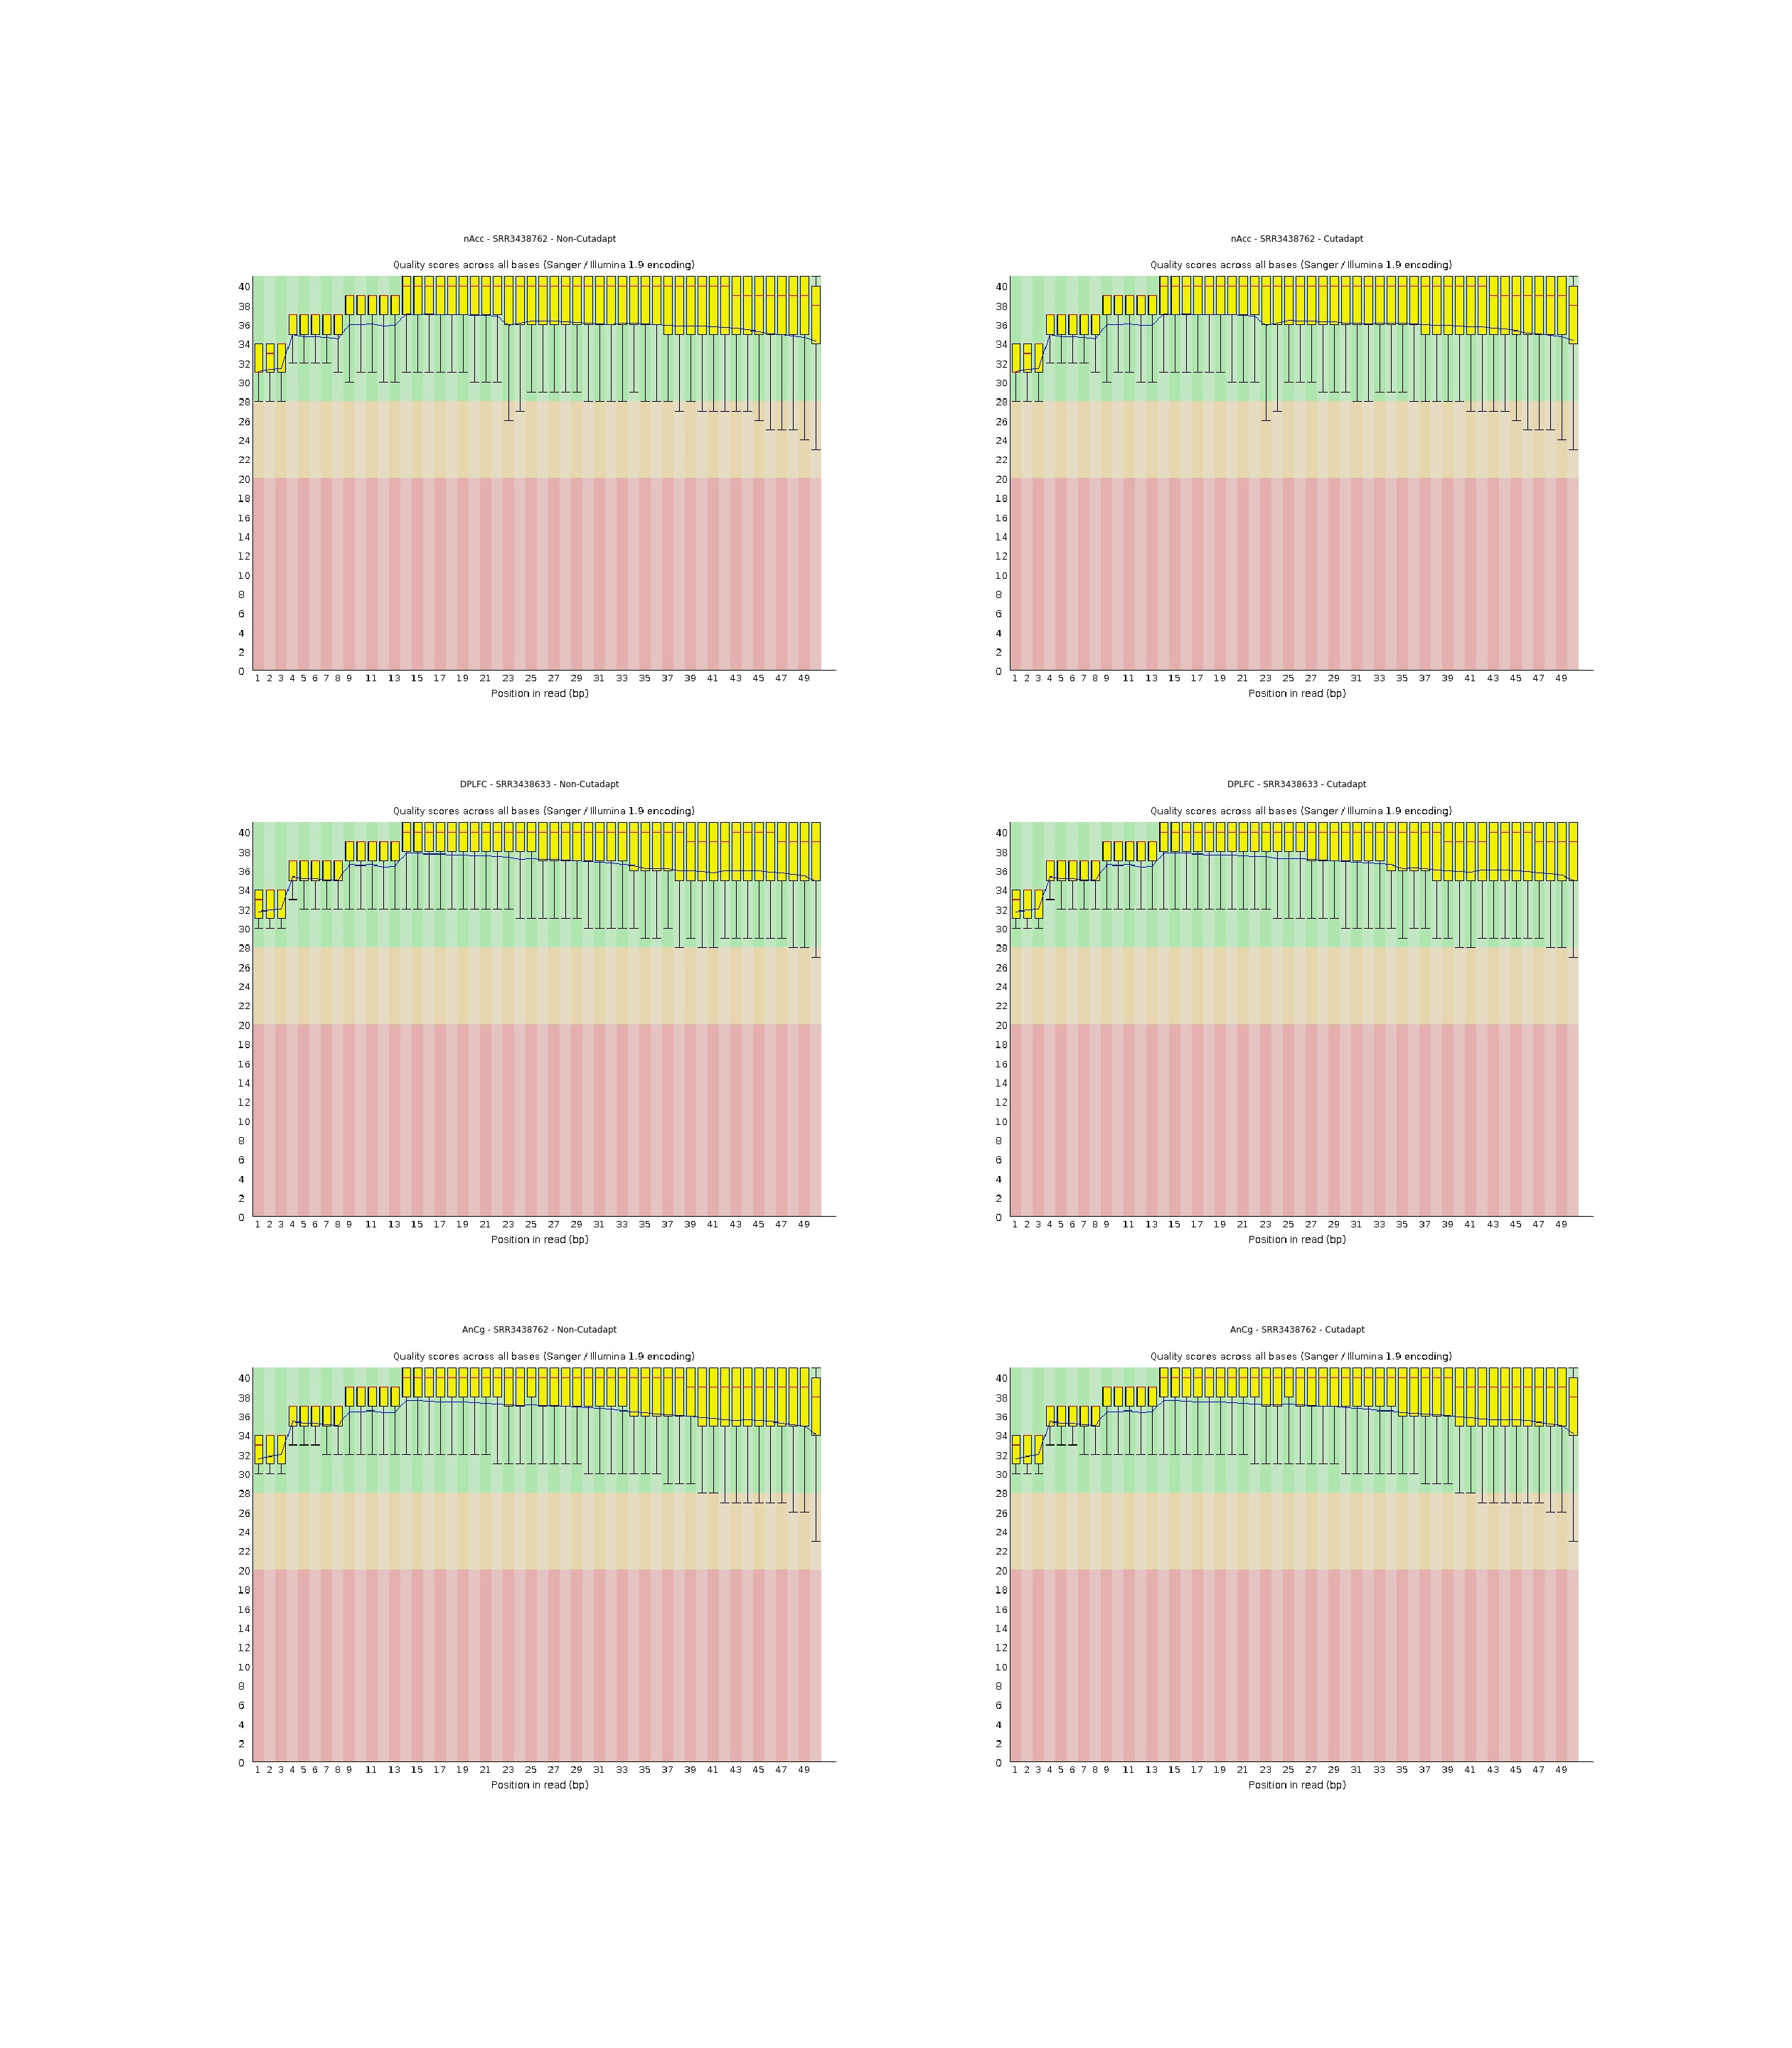

In [7]:
Image("cutadapt.png")

Figure 2: (Left) Per Base Sequence Quality visual from FastQC reports of samples, one for each brain region, that did not have cutadapt applied. (Right) Per Base Sequence Quality visual from FastQC reports of the same samples on the left that did have FastQC applied. 

Looking at three analyses from our generated FastQC reports, one can see the lack of significant difference between our data with and without cutadapt applied. Minor differences still exist, but are not considered to alter the data drastically. One noticeable difference can be seen in the Per Base Sequence Content analysis on the report. This particular analysis fails with the cutadapt applied data due to the composition biased at the end of reads as a result of adapters being removed[<sup>7</sup>](#fn7). This is expected and therefore irrelevant information when comparing the reports. Aside from the visual analysis, we also looked into the fastqc_data.txt files for each output of each sample. The txt files are included as part of the FastQC report and quicker evaulation of the data. We specifically observed the "Basic Statistics" statistics for each report and found that both the non-cutadapt applied data and the cutadapt applied data passed the standards set by FastQC. Based on our test results, it seems running cutadapt on our raw data will not provide any significant advantageous when it comes to assessing the quality of the data. Therefore it seems unlikely that we will utilize cutadapt as part of our replication project. From our own observations, the raw data is already in a satisfactory condition where we can ignore potential issues within our analyses such as biases in the data caused by its imperfections. The additional time and resources needed to be dedicated to run cutadapt on all of our sample data, we think, could be used elsewhere in our replication project.

## EDA

### Experiments Features Table

In [2]:
sra_data = pd.read_csv("../../datasets/srp073813/reference/SraRunTable.csv")
# removal of categorical column types
sra_data = sra_data.drop(["Assay Type", "AvgSpotLen", "BioProject", "Center Name",
                            "Consent", "Instrument", "LibrarySource", "LibraryLayout", "LibrarySelection"
                            , "Organism", "Platform", "TISSUE"], axis=1)

## General Patient Population

We performed EDA on our dataset to get acquire a general sense of the data and its contents. To begin, we first removed several columns that were either unnecessary, contained categorical data, and/or contained repeated values that offered no significance. This modified dataframe, "sra_data", is the dataframe in which the rest of our EDA is based on. Table 2 and Table 3 below describe our dataset as a whole, taking into account both the male and female population. 

In [73]:
# General Data Description
gen_descrp = sra_data.drop(["Bytes","Bases"], axis=1)
gen_descrp.describe().round(3)

,age_at_death,Brain_pH,post-mortem_interval
count,352.000,349.000,352.000
mean,46.420,6.901,22.827
std,12.737,0.176,7.640
min,19.000,6.520,6.250
25%,39.000,6.770,17.200
50%,47.000,6.900,24.000
75%,55.000,7.020,28.000
max,72.000,7.390,44.250


Table 2: A table that shows the descriptive analysis of our data with the general population which takes into account both males and females. Each row contains the values associated with the specific statistic metric assigned in the index of the dataframe.

In [8]:
# Data Description broken down by Gender and Clinical Diagnosis
gender_info = sra_data.groupby(['gender','clinical_diagnosis'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
gender_info = gender_info.unstack(level=0)
gender_info.round(3)

age_at_death         Brain_pH        post-mortem_interval  \
gender                   female    male   female   male               female   
clinical_diagnosis                                                             
Bipolar Disorder         49.111  48.950    6.745  6.838               20.291   
Control                  59.125  48.203    6.939  6.918               18.500   
Major Depression         50.478  43.014    7.072  7.027               24.257   
Schizophrenia            48.818  41.699    6.708  6.836               28.291   

                            
gender                male  
clinical_diagnosis          
Bipolar Disorder    22.834  
Control             22.316  
Major Depression    25.949  
Schizophrenia       20.478

Table 3: Descriptive analysis of our general population broken down by gender and clincial diagnosis. The index of the table represents each of the three clincial disorders and the control group. For the columns, we chose to focus on "age_at_death", "brain_pH", and "post-mortem_interval". Within each column variable, it is broken down between the male patients and female patients.

### Age at Death and Brain_pH Histogram - General Population

From our patient samples, we found the frequencies of the brain pH levels and age at death seen in Figure 3. The most frequent brain pH level was between 6.8 and 7.0, while the ages between 35 and 40 appear to be the most frequent age in which patients passed away. Brain pH levels could provide insight into the causes of pyschiatric dieseases as a growing number of research suggests there may be links between the balance of the brains pH levels and pyschiatric disorders such as schizophrenia and bipolar disorder[<sup>13</sup>](#fn13).

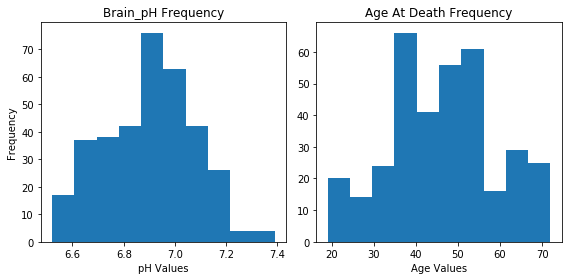

In [7]:
fig, ax = plt.subplots(1,2, figsize=(8,4),tight_layout=True)

ax[0].hist(sra_data['Brain_pH'])
ax[1].hist(sra_data["age_at_death"])

ax[0].title.set_text("Brain_pH Frequency")
ax[1].title.set_text("Age At Death Frequency")

ax[0].set_xlabel("pH Values")
ax[1].set_xlabel("Age Values")

ax[0].set_ylabel("Frequency")
x = ax[0].set_ylabel("Frequency")

Figure 3: (Left) Histogram of brain_pH frequencies from general patient samples. Mean brain_pH from our data was 6.9. (Right) Histogram of age_at_death frequences from general patient samples. Mean age at death from our data was 46.4 years old.

### Sex & Ethnicity: Males

The original replication paper noted that women were underrepresented compared to men within the data used for the study. From our analysis, we found this to be true, with 283 male patients being present compared to 69 female patients. The following analysis below attempt at showing a quantified representation of such missrepresentation in terms of both sexes and ethnicity specifically within the male sample population. The results of both perspectives question how the applicable the findings of this study can really be to a general population when the data is biased, a topic held within our class discussion groups. 

In [9]:
sra_male = sra_data.loc[sra_data['gender']=='male'].reset_index(drop=True)

### Male Patient Population Ethnicity 

Based off of Figure 4 below, the caucasian population represents a majority of the population at 90 percent and is on target with what is expected based on our readings for the course which suggests genetic studies are mainly dominated by the caucasian population.

In [47]:
# Ethnic Frequency
sra_male['ETHNICITY'].value_counts(normalize=True).round(3)

Caucasian           0.901
African American    0.032
Asian               0.028
Other               0.025
Pacific Islander    0.014
Name: ETHNICITY, dtype: float64

Figure 4: Ethnic break down of the male patient population in our data.  

### Male Data Description Broken Down By Gender and Clinical Diagnosis

In [46]:
# Data Description broken down by Gender and Clinical Diagnosis
ethnicity_breakdown = sra_male.groupby(['ETHNICITY','clinical_diagnosis'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
ethnicity_breakdown

age_at_death  Brain_pH  \
ETHNICITY        clinical_diagnosis                           
African American Control                65.000000  6.880000   
                 Schizophrenia          39.000000  6.710000   
Asian            Control                43.000000  7.100000   
                 Schizophrenia          35.000000  6.610000   
Caucasian        Bipolar Disorder       48.946429  6.835357   
                 Control                47.731343  6.919104   
                 Major Depression       43.014085  7.027465   
                 Schizophrenia          42.114754  6.858793   
Other            Bipolar Disorder       49.000000  6.870000   
                 Schizophrenia          48.000000  6.930000   
Pacific Islander Control                39.000000  6.810000   

                                     post-mortem_interval  
ETHNICITY        clinical_diagnosis                        
African American Control                        13.500000  
                 Schizophrenia                  19.000000  
Asian            Control                        26.000000  
                 Schizophrenia                  26.500000  
Caucasian        Bipolar Disorder               22.358036  
                 Control                        23.057463  
                 Major Depression               25.949296  
                 Schizophrenia                  19.760656  
Other            Bipolar Disorder               29.500000  
                 Schizophrenia                  27.000000  
Pacific Islander Control                        18.150000

Table 4: For each ethnicity identified in the male patient population, we have shown descriptive analysis for the three brain disorders and the control group found in each ethnicity.

### Sex & Ethnicity: Female

Similar to the figures shown for the male population, the information below continue to show the bias that exists within available data used for genetics studies. In this particular case, the underrepresentation of women in the replication project is noted, but nothing is mentioned of the ethnicity within the female population. Our insight into this found the entire female population to be Caucasian seen in Table 5 below. 

In [11]:
sra_female = sra_data.loc[sra_data['gender']=='female'].reset_index(drop=True)

In [12]:
# Data Description broken down by Gender and Clinical Diagnosis
ethnicity_breakdown = sra_female.groupby(['ETHNICITY','clinical_diagnosis'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
ethnicity_breakdown.round(3)

age_at_death  Brain_pH  post-mortem_interval
ETHNICITY clinical_diagnosis                                              
Caucasian Bipolar Disorder          49.111     6.745                20.291
          Control                   59.125     6.939                18.500
          Major Depression          50.478     7.072                24.257
          Schizophrenia             48.818     6.708                28.291

Table 5: Similar to Table 4, for each ethnicity identified in the female population, descriptive analysis for the three brain disorders and the control group are shown. The female population in our dataset, however, were all considered caucasian.

## Brain Region

During our EDA of the three brain regions specified in the replication project, we narrowed our focus on seeing how correlated the three brain regions of the study were when it came to the variables 'age_at_death", "Brain_pH", and "post-mortem_interval". The findings when it came to the anterior cingulate cortex (AnCg) showed it to contain the most correlated values compared to the other two regions. Throughout the remainder of the project, much of the significant conclusions of the project would involve the AnCg.  

#### Mean Break Down of Disorders at Each Brain Region

In [45]:
# Averages broken down by source_name
region_info = sra_data.groupby(['source_name'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
region_info.round(3)

,age_at_death,Brain_pH,post-mortem_interval
source_name,,,
AnCg_Bipolar Disorder,47.643,6.803,22.120
AnCg_Control,49.867,6.924,21.995
AnCg_Major Depression,45.133,7.048,25.373
AnCg_Schizophrenia,41.429,6.811,21.029
DLPFC_Bipolar Disorder,49.429,6.821,22.705
DLPFC_Control,47.767,6.914,21.850
DLPFC_Major Depression,45.742,7.038,24.913
DLPFC_Schizophrenia,43.276,6.826,21.317
nAcc_Bipolar Disorder,49.839,6.803,21.381


Table 6: Table showing the mean values of "age_at_death", "brain_pH", and "post-mortem_interval" for the three brain disorders and the control group. Each row of the table represents a particular brain region and a brain disorder group or control group for that region.

#### Correlation Obersvation of the Anterior Cingulate Cortex

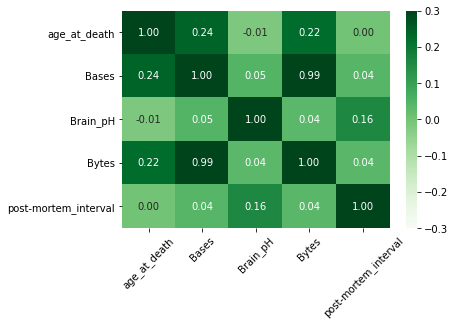

,age_at_death,Bases,Brain_pH,Bytes,post-mortem_interval
age_at_death,1.000,0.243,-0.014,0.223,0.003
Bases,0.243,1.000,0.049,0.990,0.044
Brain_pH,-0.014,0.049,1.000,0.036,0.161
Bytes,0.223,0.990,0.036,1.000,0.038
post-mortem_interval,0.003,0.044,0.161,0.038,1.000


In [48]:
# AnCg Correlation Observation
AnCg_region = sra_data[sra_data['source_name'].str.contains("AnCg")]
AnCg_corr_data = AnCg_region.corr()
sns.heatmap(AnCg_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

AnCg_corr_data.round(3)

Figure 6 (Top): Heatmap showing the correlations between the quantitative variables found in our dataset. The darker the shade of green, the more correlated the two variables are. The larger the value shown in each box of the heatmap, the greater the correlation as well.

Table 7 (Bottom): Table representation of the correlation values from Figure 6 above. The closer the value is to 1, the greater the correlation between two variables.

## Unique Samples vs Duplicate Samples per Patient

During the EDA we found that 271 of the 351 samples were uniquely assigned to a patient and brain region. However, there were 67 that had repeated SRA runs, and 2 cases that had 3 SRA runs. If we had more time we would have pursued a further analysis of these repeated samples, in particular we would eliminate the repeating samples based on a quality check (e.g. using cutadapt). However, due to lack of time we decided to keep all repeated samples in our analysis.

1    212
2     67
3      2
Name: BioSample, dtype: int64

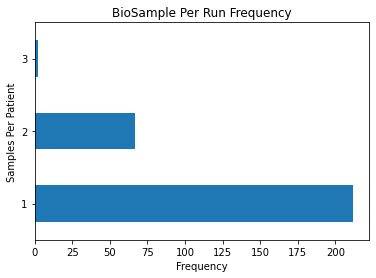

In [16]:
ax = sra_data["BioSample"].value_counts().value_counts().plot(kind='barh')
ax.set_xlabel("Frequency")
ax = ax.set_ylabel("Samples Per Patient")
plt.title("BioSample Per Run Frequency")

sra_data["BioSample"].value_counts().value_counts()

## Processing of Data

### Gene counting: STAR vs kallisto

Our original plan was to use STAR for alignment and gene counting howwever we decided to leverage kallisto. This decision might impact the quality of the gene count results and differs with the original research paper; however, due to slow performance of STAR we decided to proceed with processing the SRA dataset with kallisto. The kallisto processing still required several days which we executed on our pipeline on the DSLMP server. 

### Merging counts

Kallisto generates a TSV abundance file per SRA run sample. The table has a column that indicates the abundance count. The 350 abundance files were merged into one gene count file. Special care was needed to ensure that the columns and rows matches up - the columns were the SRA runs, and the rows were the gene counts. The output was a table with over 78K genes. However, as mentioned in the research paper, X and Y chromosomes were not considered in the analysis, and after removing these, as well as the genes prefixed with NR accession prefix, this yielded 60,6042 genes. Further cleanup of this to remove false positive resulted in 17,162 genes.  Finally, we also removed the sample: SRR3438888, that we investigated during EDA had null data generated from kallisto. A portion of the final gene matrix table is shown in Table 8 below. 

In [57]:
df1 = pd.read_csv("../data/out/gene_matrix.tsv", sep='\t', index_col=0)
df1.iloc[0:6:,0:6].round(3)

,SRR3438897,SRR3438649,SRR3438740,SRR3438726,SRR3438727,SRR3438767
0,,,,,,
NM_000014.6,112.114,41.817,58.748,85.004,77.419,34.565
NM_000015.3,0.177,0.191,0.202,0.616,0.053,0.201
NM_000016.6,28.859,24.180,11.067,30.071,32.739,18.380
NM_000017.4,14.192,40.359,15.909,14.154,11.147,11.978
NM_000018.4,126.622,173.095,104.262,128.341,113.164,173.999
NM_000019.4,14.234,24.146,0.000,31.468,35.343,12.590


Table 8: Subset of the gene matrix showing the first 6 SRA Run's and the first 6 genes. 

Another output of the merge step was to generate the feature experiment table. This had the SRA Run's as rows and the pertinent features as columns. As in the research paper we selected the disorder, age, brain region, brain pH and PMI. One thing we did not have access was the Percentage of Reads Uniquely Aligned (PRUA), as we did not use STAR. The feature table, Table 9, is shown below with 350 SRA runs, and the 5 feature labels.

In [58]:
df2 = pd.read_csv("../data/out/features.tsv", sep='\t', index_col=0)
df2

,Disorder,Age,pH,brain_region,PMI
Run,,,,,
SRR3438555,Control,40,6.76,AnCg,12.25
SRR3438556,Major Depression,58,6.93,AnCg,24.00
SRR3438557,Bipolar Disorder,56,6.83,AnCg,29.00
SRR3438558,Major Depression,49,7.19,AnCg,27.00
SRR3438559,Schizophrenia,31,6.77,nAcc,22.00
...,...,...,...,...,...
SRR3438902,Schizophrenia,36,6.82,nAcc,11.20
SRR3438903,Schizophrenia,52,6.89,nAcc,23.50
SRR3438904,Schizophrenia,50,6.64,nAcc,25.70


Table 9: Feature table which has features we are interested for all the SRA Run's. 

### Normalized Gene Count 

The process of normalization used the merged gene matrix and feature experiment table generated from the merge step, and then used DESeq2's transform to generate a normalized count matrix file. As well as outputing the standard normalized count matrix we also performed Variance Stabilization Transformation (VST) to generate an additional normalized matrix which used the parametric fitting type. VST transforms data is by creating new values in terms of y where the variability of the new y-values is unrelated to the x-values[<sup>11</sup>](#fn11). VST finds a function that can be applied to the original x values to generate the new y-values. Methods like VST and normalization allow us to primarily scale our data so that its in a format that allows us to perform further analysis. The values in our data become more manageable all while still maintaing their original statistical importance and meaning, especially if our variables in our pre-normalized data have different scales[<sup>12</sup>](#fn12).

The descriptive statistics for both the normalized and the VST normalized gene matrix is shown in Table 10 and 11 below. 

In [64]:
pd.set_option('display.max_rows', 8)
df3 = pd.read_csv("../data/out/normalized_counts.tsv", sep='\t', index_col=0)
print("Normalized Gene Matrix Descriptive Statistics:")
df3.describe().mean(axis=1).to_frame().rename({0:"Average Sample"}, axis=1).round(3)

Normalized Gene Matrix Descriptive Statistics:


,Average Sample
count,17162.000
mean,29.882
std,249.569
min,1.036
25%,1.052
50%,4.917
75%,19.141
max,26484.183


Table 10: Normalized gene matrix descriptive statistics summarized for all samples.

In [66]:
pd.set_option('display.max_rows', 8)
print("VST Gene Matrix Descriptive Statistics:")
df3 = pd.read_csv("../data/out/vst_transformed_counts.tsv", sep='\t', index_col=0)
df3.describe().mean(axis=1).to_frame().rename({0:"Average Sample"}, axis=1).round(3)

VST Gene Matrix Descriptive Statistics:


,Average Sample
count,17162.000
mean,2.324
std,2.127
min,0.350
25%,0.358
50%,1.646
75%,3.522
max,13.789


Table 11: VST gene matrix descriptive statistics summarized for all samples.

The descriptive statistics showed as expected the VST had a smaller range of values. However, we wanted to verify that the two sets of normalized gene count matrices where correlated. For this we took a number of SRA samples from each matrix and compared them against each other. Figure 7 below shows the correlation for SRR348555 as well as SRR3438560. The result of the R2 Pearson correlation of 0.97 shows a strong indication that the data from both matrices is consistent. For further downstream processing, we used the VST gene matrix.

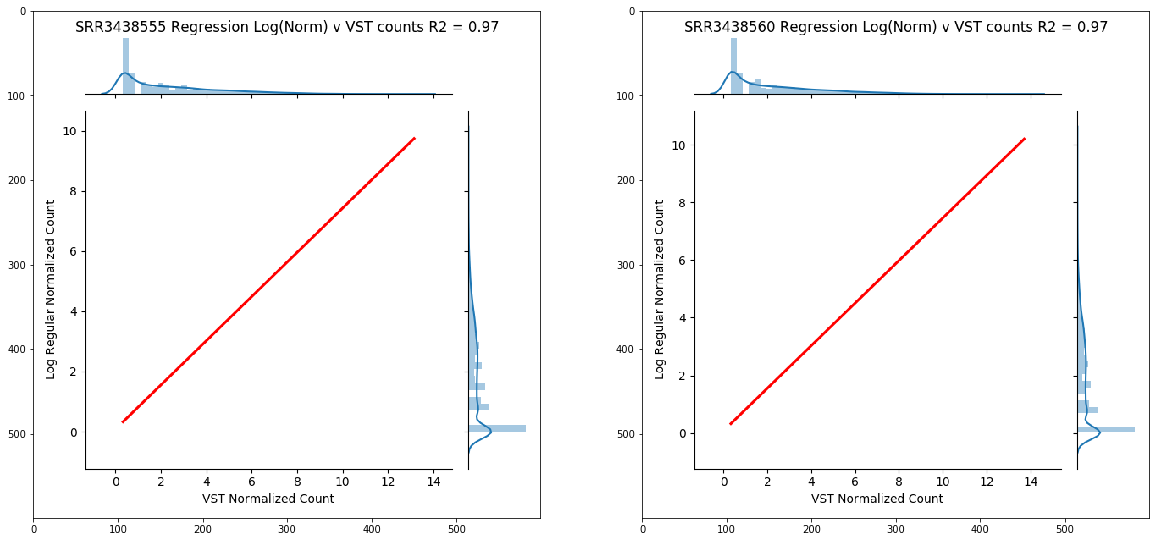

In [2]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/sra_1.png')
img_B = mpimg.imread('../data/out/sra_2.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);


Figure 7: Two SRA Run's regression of log norm vs VST counts. 

### PCA

We performed Principle Component Analysis (PCA) on the VST gene matrix for two PCA Plots, one with the grouping set to disorder, and another plot with the grouping set to brain region. 

PCA uses linear combinations to explain the variance-covariance structure of a set of variables. Data reduction and data interpretation are the main reasons for the use of PCA with the latter being the method we incorporated in the replication project[<sup>8</sup>](#fn8). For the purposes of this project, we did not remove any samples from our data thus negating the need to do any sort of dimensionality reduction of our data. In doing so, we did not experience any reduction in our data in terms of size and scope which would be commmon in other PCA implementations. We used PCA purely on an exploratory level where we could observe relationships within our data that may not have been as obvious to us. 
In Figure 8 below, there are visibly two groups formed in both the left and right charts. However, the spread of every disorder and brain region, respectively, is relatively equal across the chart.


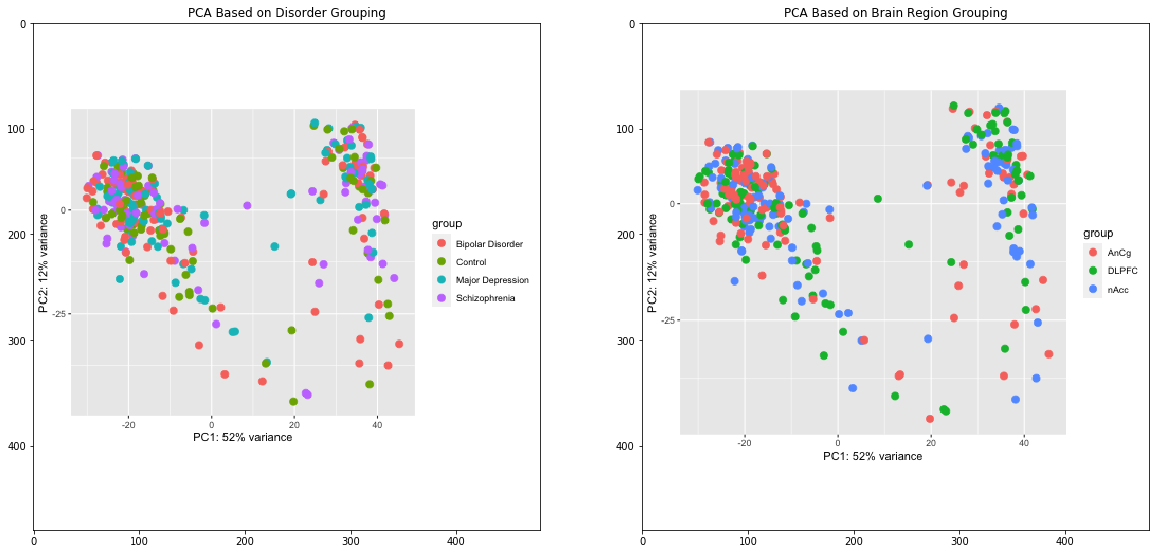

In [67]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/PCAplot_Disorder.png')
img_B = mpimg.imread('../data/out/PCAplot_BrainRegion.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);

title = ax[0].set_title("PCA Based on Disorder Grouping")
title = ax[1].set_title("PCA Based on Brain Region Grouping")



Figure 8: (left) PCA based on grouping by disorder. (right) PCA based on grouping by brain region.

### Removing Non Varying Genes
Many of the 16K genes are not relevant for analysis and thus compromise the quality and performance of the analysis. We can identify these genes by calculating a statistic for each gene across the samples that measures the spread against the mean normalized count. Genes which had little spread are likely candidates to remove as they do not significantly vary across the samples. The spread statistic we developed was the L1 distance against the mean. 
The table below shows the top 5 and bottom 5 genes and the spread values. The gene with highest count variance was NM_020309.4 and the bottom ranked gene was NM_001001953.1. Finally, a gene that was mentioned in the paper, EGR1 (NM_001964), was ranked number 691. This ranking could indicate some potential data quality issues resulting from kallisto which was not used for gene counting in the original study. 

In [78]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


df3 = pd.read_csv("../data/out/top_genes.tsv", sep='\t', index_col=0)
df3 = df3.rename({"gene": "Gene"}, axis=1)
display_side_by_side([df3.iloc[:5,:], df3.iloc[-5:,:]], ['Top Ranked Genes', 'Bottom Ranked Genes'])


,Gene,Spread
0,NM_001105579.2,1236.62
1,NM_001135690.3,1214.03
2,NM_020309.4,1201.94
3,NM_000795.4,969.265
4,NM_005413.4,871.788
,Gene,Spread
17157,NM_001001656.3,10.0899
17158,NM_007035.4,10.0899
17159,NM_005068.3,10.0899
17160,NM_032147.5,10.0899


Table 12: (left) the top ranked genes and their spread. (right) the bottom ranked genes and their spread.

We can visualize the distribution of the spread measure across all the genes and the top 8000 genes (the number 8000 was based on estimating the number of genes relevant in the visualization for the original paper). The "top" genes are the ones with the higher spread. From the histogram in Figure 9 below we can also see the peak of over 2000 genes that have little spread and can be thought of as noise. 

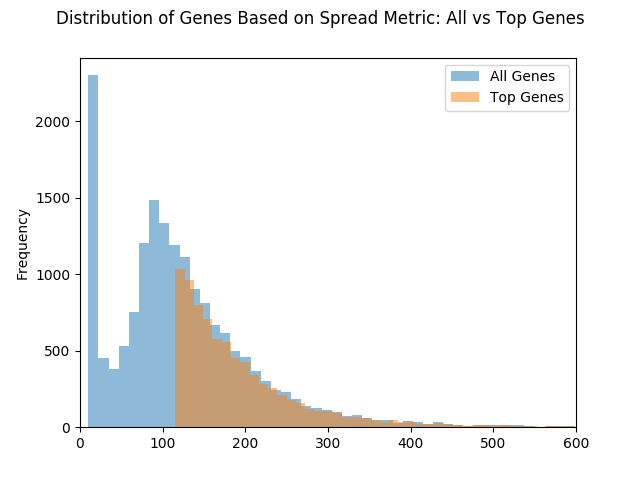

In [5]:
Image("../data/out/top_genes.png", width=300)

Figure 9: Histogram showing the distribution of genes based on the spread variance of all the genes versus the top genes. 

## Data Analysis

The analysis of the data was performed using the same technique in the research paper, namely to consider each brain region separately, and within inside each brain region to consider each disorder (versus control) separately. This resulted in 9 combinations of analysis computations that were performed.  

Prior to performing the analysis, the gene matrix table was reduced to the top 8000 genes as defined by the PCA ranking. This was not hard-coded and can be changed based on the parameter configuration files. 

With the top genes identified, each of the 3 brain regions ("AnCg", "nAcc", "DLPFC") we filtered only the samples for that brain region and then further break into 3 different tables where we would only include one of the three disorders ("Major Depressive Disorder", "Schizophrenia", "Bipolar Disorder") plus the control.

The basis of the analysis was the Likelihood Ratio Test (LRT), which is a hypothesis test based on a full and reduced model using the DESeq2 package. The full model was Age+PMI+pH+Disorder, and the reduced model was Age+PMI+pH. The premise of the LRT is to compare models in terms of how they fit the available data by comparing the likelihood scores of the two models[<sup>9</sup>](#fn9). The model with the higher score is considered the model that best fits the data. In order to properly use the LRT, the models being compared must be nested models meaning one model must be a "simpler" version of the other[<sup>9</sup>](#fn9). In our case, the "simpler" model is our reduced model, while our full model represents out complex model. 

Our process for LRT in this replication project differs from the original paper in that the PRUA was not included, which as mentioned earlier was due to not having this statistic readily available due to our choice of using kallisto. The output from the analysis was a LRT table which included the baseMean, log2 Fold Change, stat, the pvalue, and adjusted pvalue. The descriptive summary of LRT in brain region AnCg for Major Depressive Disorder is shown in Table 13 below.

In [70]:
df4 = pd.read_csv("../data/out/AnCg/Major_Depression/lrt.tsv", sep='\t', index_col=0)
df4.describe().round(3)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
count,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000
mean,53.476,0.002,0.151,0.783,0.548,1.000
std,279.363,0.140,0.075,2.145,0.282,0.011
min,1.997,-1.169,0.042,-80.813,0.000,0.000
25%,7.239,-0.075,0.096,0.069,0.316,1.000
50%,17.683,-0.006,0.135,0.329,0.566,1.000
75%,42.809,0.073,0.193,1.007,0.792,1.000
max,21353.539,1.573,1.316,110.675,1.000,1.000


Table 13: The LRT descriptive summary for brain region AnCg for Major Depressive Disorder.

## Visualization

### MA Plot

The LRT data for each of the 9 comparisons was used to generate a 3x3 MA Plot shown in Figure 10 below. This is a scatter plot of the mean of the normalized counts against the log fold change. The striking pattern we can see is that the brain region AnCg and the disorder for Schizophrenia shows many outliers. Our findings for the MA Plot results between schizophrenia and the anterior cingulate cortex are inline with the behavior observed by data of the schizophrenic samples within the specific brain region. Specifically, the original replication report notes that schizophrenic samples in the AnCg showed the most significant disease-related differences compared to those of the control groups[<sup>1</sup>](#fn1).


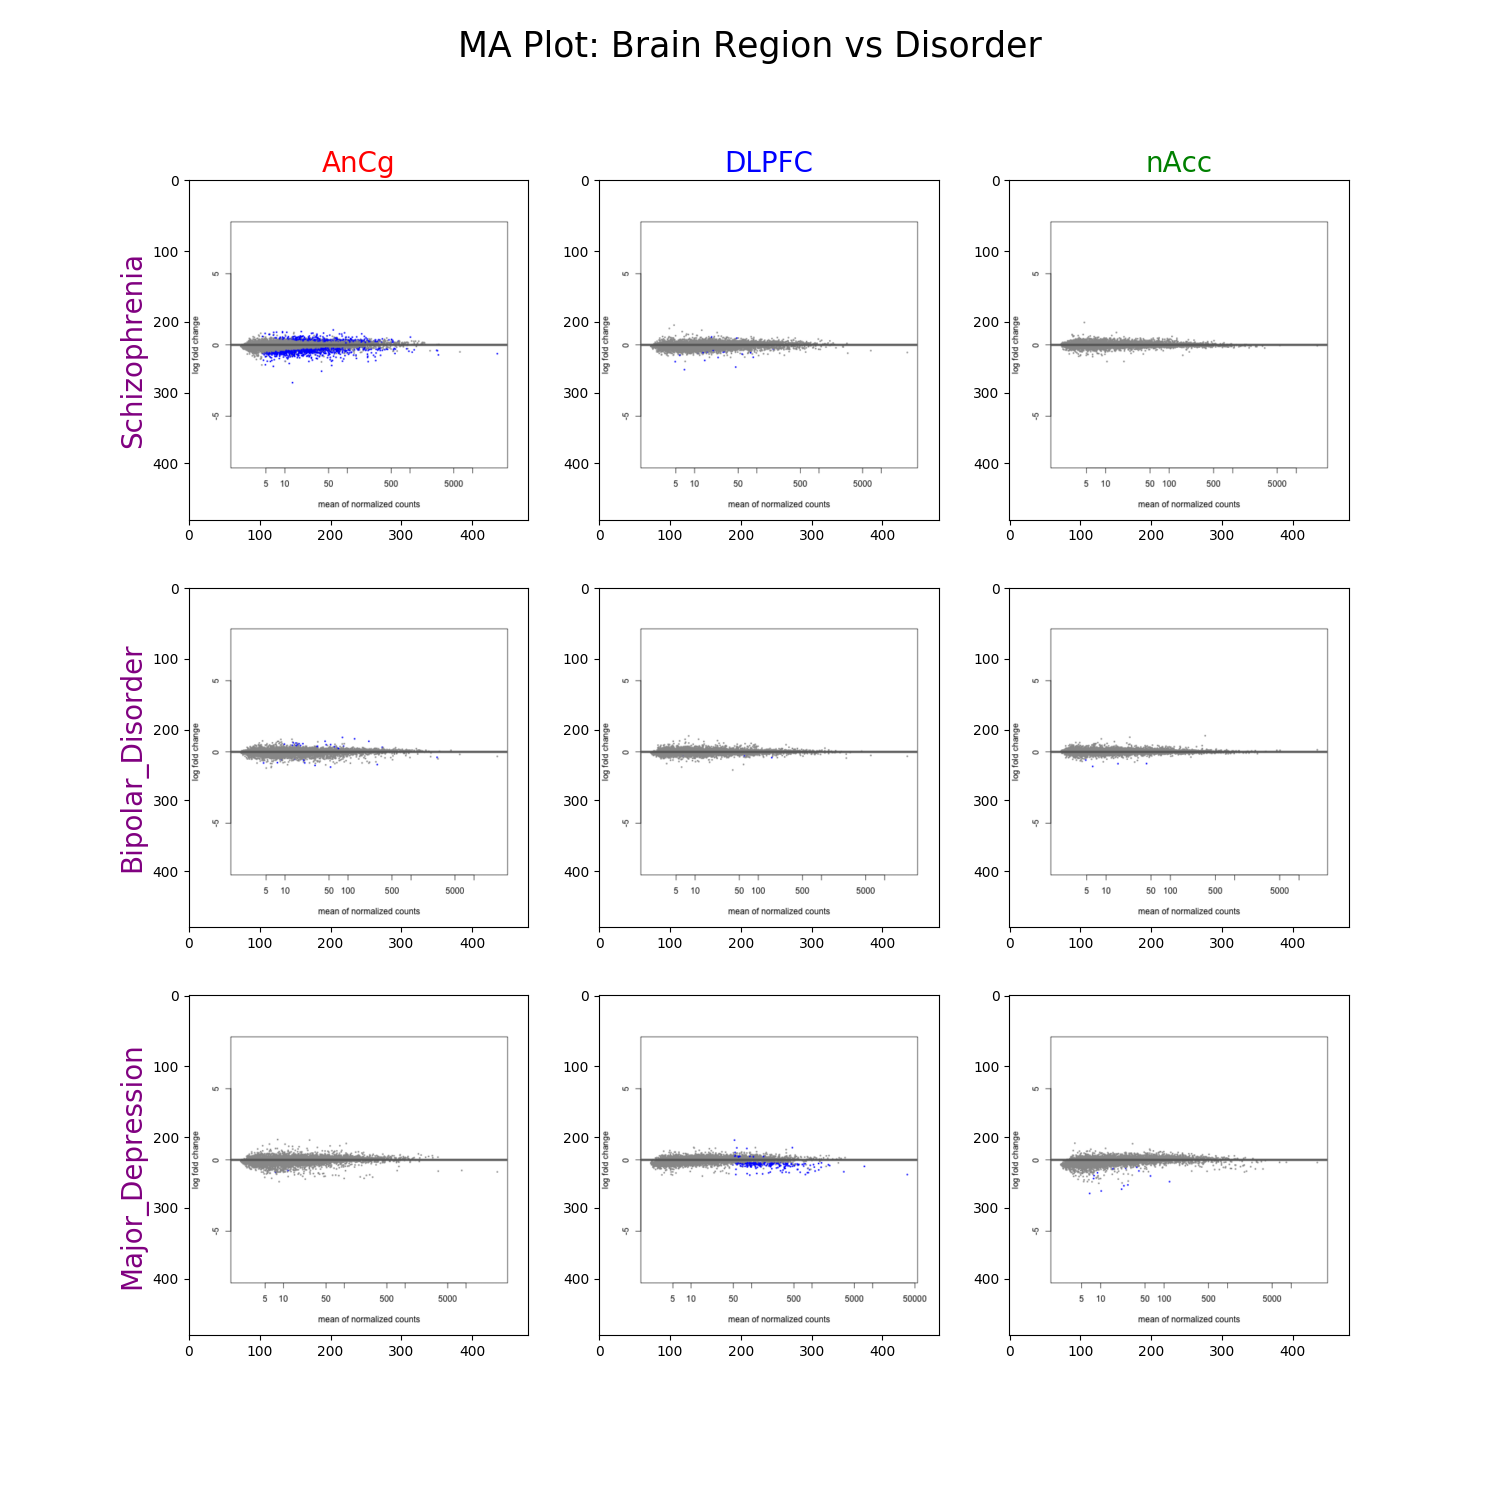

In [31]:
Image("../data/out/ma_plot.png", width=500)

Figure 10: MA Plot for each brain region versus each disorder.

### Heat Maps

The LRT data for each of the 9 analysis regions was used to generate a 3x3 heatmaps of the top 1000 genes is shown in Figure 11 below. Heatmaps allow us to observe specific values of interest across two axis variables in the form of a grid with colored cells[<sup>10</sup>](#fn10). The variables we have used for our axes are the patients and the genes identified across our patient samples, with the main value of interest being the expression of genes between patients and specific genes, which was a similar approach seen in the original replication paper. By observing our value of interest, gene expression, we can then be able to determine if any patterns or associations exist within our 9 analysis regions. Figure 11 shows clustering analysis which is particulalry suited to the VST data. Although it is difficult to interpret the minute details in each chart, we can see that two areas are more different than others: Major Depressive in both the brain regions of DLPFC and nAcc show striking differences to the rest of the heatmaps.

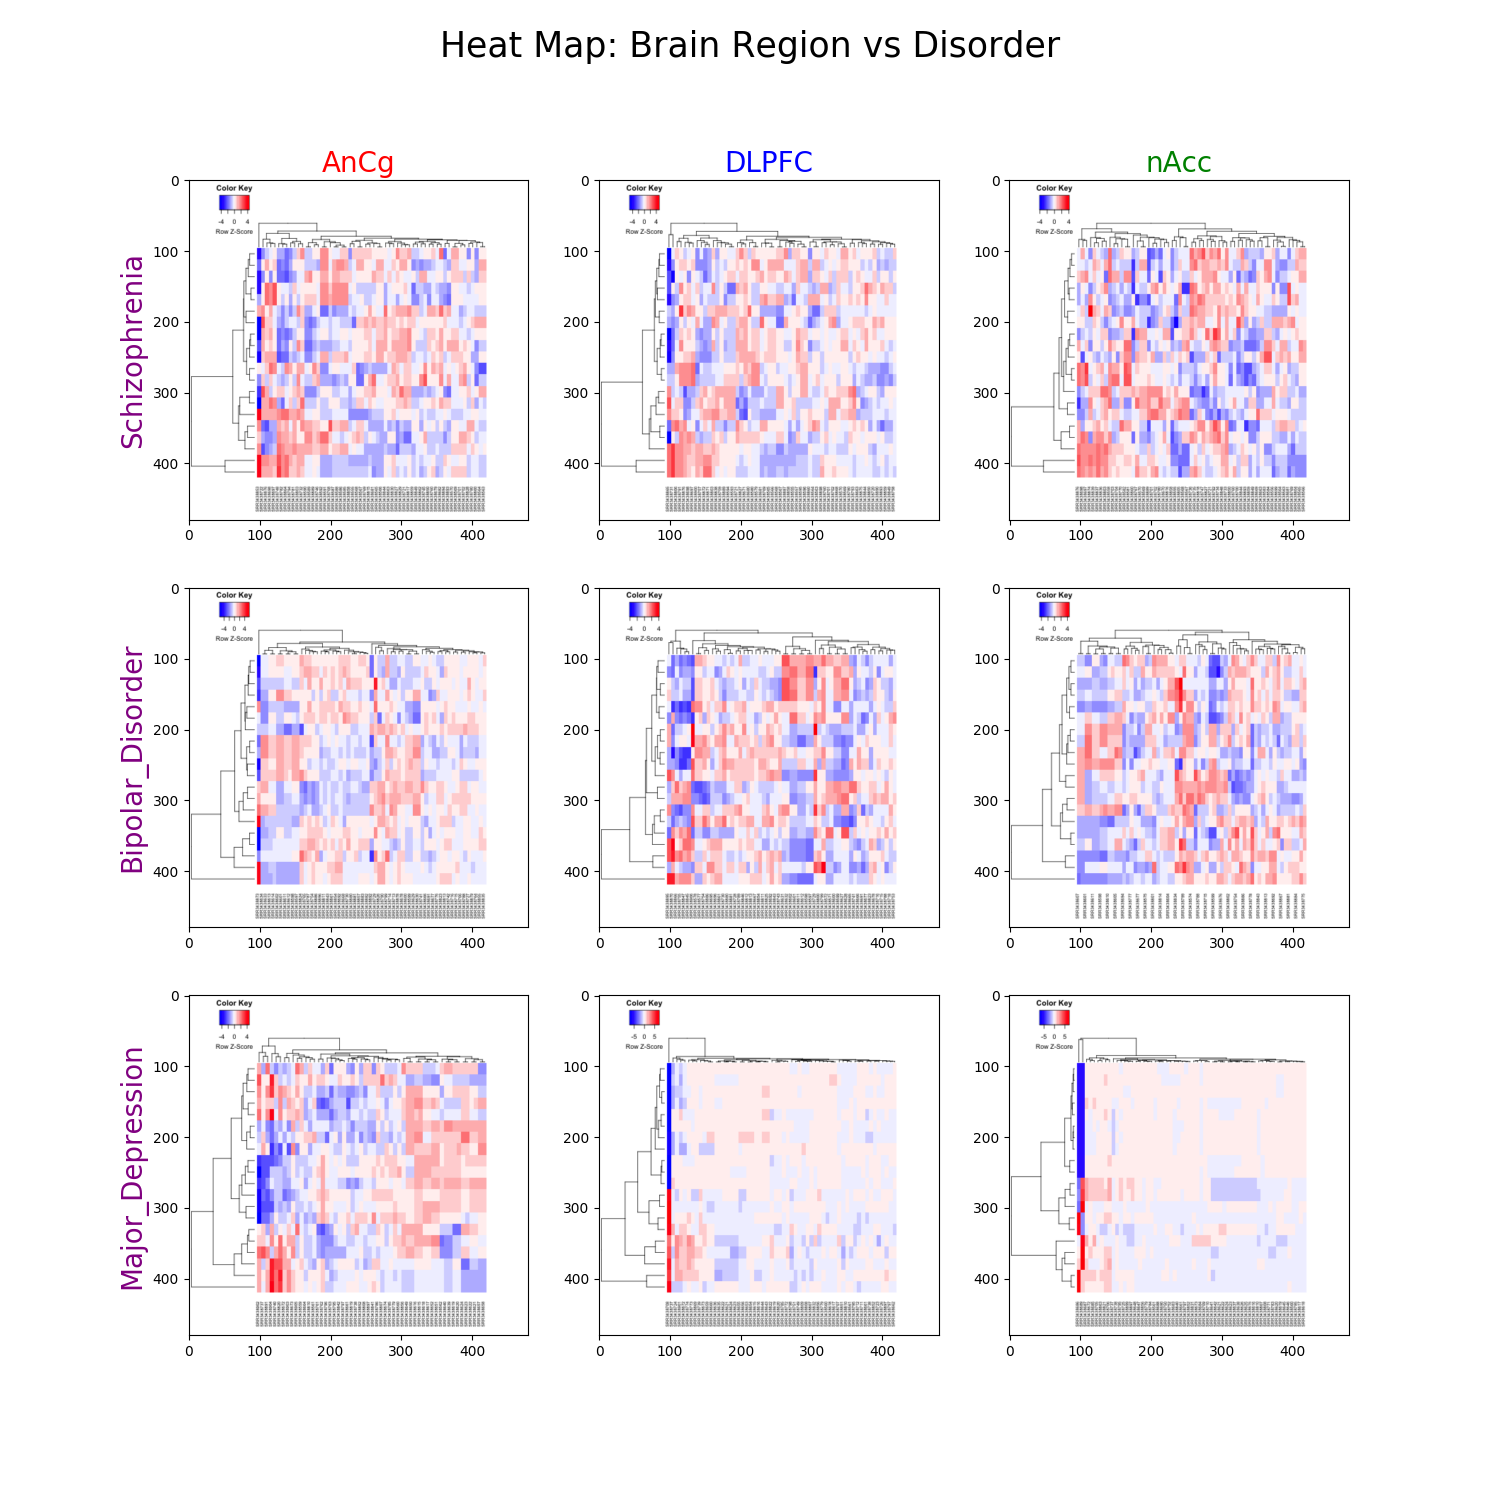

In [32]:
Image("../data/out/heat_map.png", width=500)

Figure 11: Top 1000 Expressed Gene Heatmap for each brain region versus each disorder.

### Histograms of case versus control differential expression

We repeat the same visualization in the paper for the distribution of the pvalues for each of the 9 regions shown in Figure 12 below. We see a similar profile for the Schizophrenia histograms - AnCg has a distribution which has a right skewed with a high number of samples with high statistical significance. Similarly, Schizophrenia histograms for DLPFC and nAcc show a flattish distribution. The Bipolar Disorder for AnCg also shows a similar right skewed distribution with a lower peak than Schizophrenia in this same brain region. The distributions for the other regions is not exactly the same as in the paper. However, given the large number of differences in the processing pipeline, in particular the use of kallisto, there is still a reasonable degree of correlation in these results.

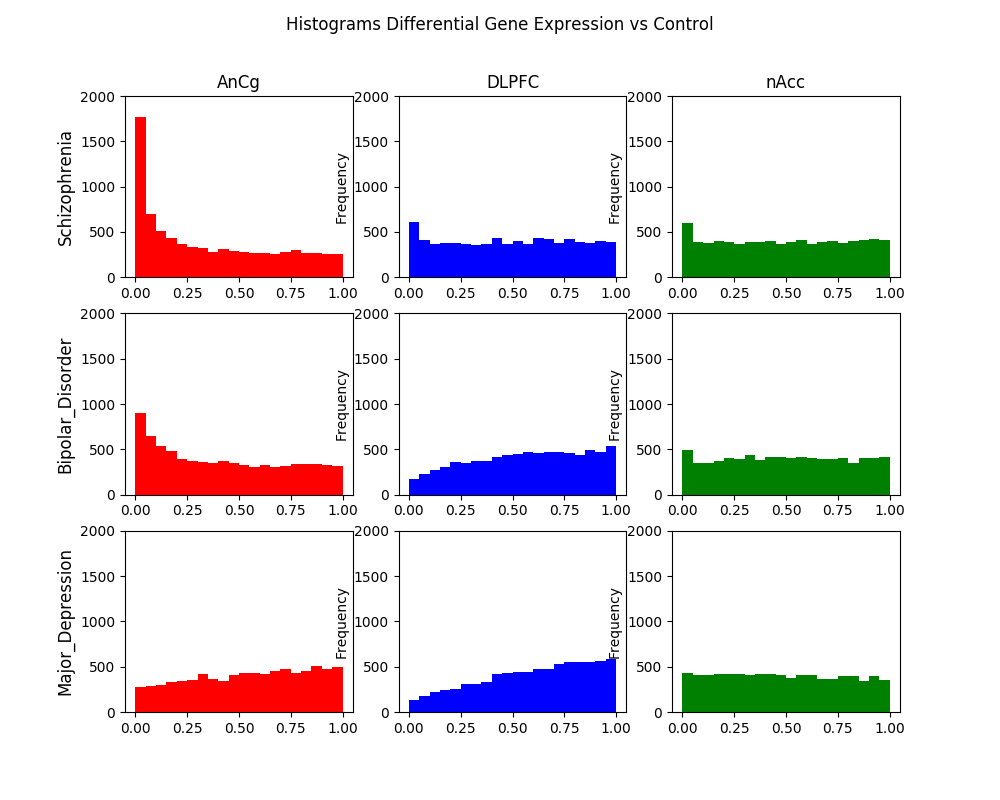

In [72]:
Image("../data/out/histogram.png", width=800)

Figure 12 - Histogram for each brain region versus each disorder.

### Venn Diagram of Disorders 

Another visualization in the original paper is a venn diagram that shows overlap of genes differentially expressed between SZ (red), BPD (green), and MDD (blue) versus CTL at p value <0.05 in the AnCg, our venn diagram is shown below in Figure 13. The actual numbers are different and is to be expected as we do not know the exact number of genes that were dropped as part of PCA in the research paper. However, there is a significant divergence in the Major Depressive Disorder with only 312 counts measured which indicates that our analysis is not replicating the same results in this disorder - this was also seen in the histogram analysis mentioned above too. This is a potential area to investigate and debug to find the cause of this divergence.

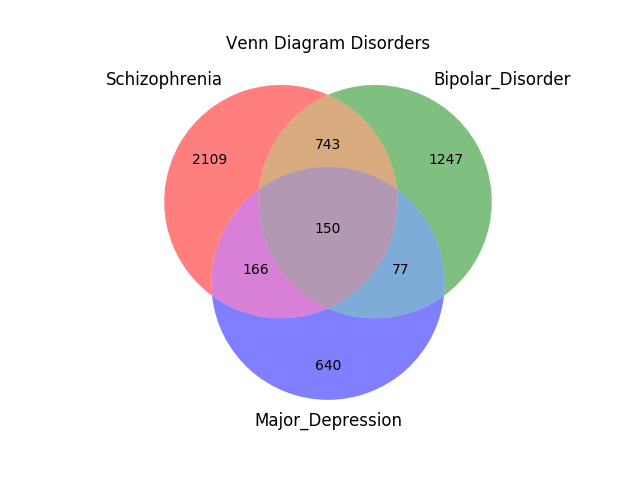

In [10]:
Image("../data/out/venn.png", width=600)

Figure 13: Venn Diagram showing genetic overlap between SZ, BPD, and MDD.

### Spearman correlations of log2 fold gene expression 

We finally recreate the spearman correlation matrix that is pairwise Spearman correlations of log2 fold gene expression changes between each disorder and CTL in each brain region. The circle sizes are scaled to reflect absolute Spearman correlations. To produce this plot we took the log2 fold gene expressions column from each of the 9 LRT analyses we performed and then use Panda's correlation function to generate a R2 pearson correlation number.

The results are shown below in Figure 14. One particularly interesting point is that we see a high degree of correlation between Schizophrenia and Bipolar disorders in the AnCg brain region, this was also noted in the research paper and is a likely confirmation that our results have some level of validity. 


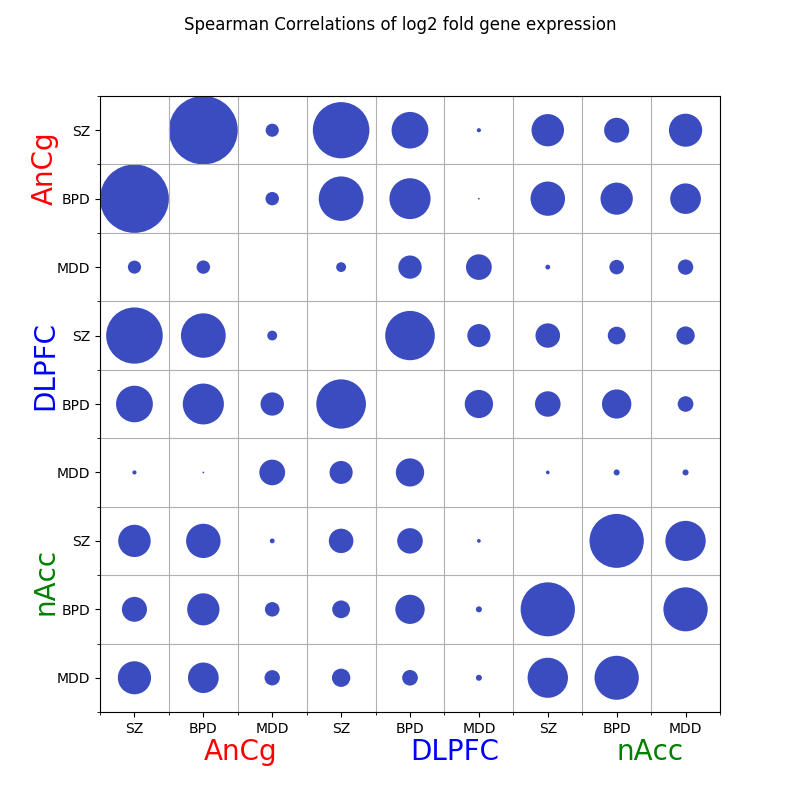

In [11]:
Image("../data/out/corrmatrix.png", width=600)

Figure 14 - Spearman correlation of log2 fold gene expression for each brain region against each disorder.

## Conclusion

We have shown a reproduction of the brain and disorder analysis using gene expressions. To accomplish this we have developed a robust pipeline which takes SRA fastq files and outputs visualizations that are in the original paper. Although we do not match the exact results, we have shown that we do find that there is a high degree of correlation in the AnCg brain region between Schizophrenia and Bipolar disorders. However, we have found our results diverge in the Major Depressive disorder. This discrepency could have occurred because of several decisions we made different from the original paper:

- We decided to develop a custom pipeline instead of using the aRNAPipe. aRNAPipe is used in the paper and is very powerful but we decided we wanted to call the tools (cutadapt, kallisto, etc) directly in our own pipeline as it gives us more ability to understand what is going on, more flexibility, and we think it will be easier to debug in the future.

- We performed gene counts with kallisto rather than STAR. This decision was based on practiciality, as kallisto is faster for processing compared to STAR. As STAR aligns to the reference genome and kallisto does pseudoalignment on the transcriptome quantification, the results will be different. Furthermore, we were not able to use the PRUA statistic from STAR in our analysis which lead our full and reduced models in the LRT to have one less feature.

Overall, this was a great learning experiance for both of the team members. Not only was it a technically challenging project from learning new tools and developing a sophisticated pipeline, but we also learned about the biology of genes and approaches of using gene expression to analyse massive real-world datasets. This project also allowed us to appreciate the data challenges that data scientists in the genetics field face, from incomplete data to massive computation challenges to clean and process the biological sample datasets. 


## Appendix 

### Project Targets

#### target: data
•	To process the data, from the root project directory run the command:

    python3 run.py data

•   The data pipeline step takes the .fastq compressed files as input and then applies two transformations: process and align

•	This pipeline step also uses an additional CSV file that is the SRA run database, a sample looks like as follows:

    Run age_at_death    Brain_pH    brain_region    Bytes   Center Name clinical_diagnosis
    SRR3438555  40  6.76    AnCg    2585349730  GEO Control



•   The configuration files for the data step are stored in config/data-params.json. These include the parameters for the tools as well as the directories used for storing the raw, temporary and output files.

    "raw_data_directory": "./data/raw",
    "tmp_data_directory": "./data/tmp",
    "out_data_directory": "./data/out",

•   The configuration also includes an attribute to the SRA run input database (described above), and an attribute of where to store that in the data folder. Additional filter attributes are included for ease of use to avoid processing all patients, if this filter_enable is set it will only process a subset of SRA rows (filter_start_row to filter_start_row + filter_num_rows).

    "sra_runs" : {
        "input_database" : "/datasets/srp073813/reference/SraRunTable.csv",
        "output_database" : "data/raw/SraRunTable.csv",
        "filter_enable" : 0,
        "filter_start_row" : 120,
        "filter_num_rows" : 10   
    },
    

•	The first transformation of the data is "process" that uses the following data configuration below. Otherwise it will invoke cutadapt which finds and removes adapter sequences. The attributes include the adapters (r1 and r2) to identify the start and end of pairs are a JSON array. The attribute enable allows to disable this cleaning step, instead it will simply copy the paired files from the source dataset. The arguments attribute allows flexible setting of any additional attribute to the cutadapt process. Finally, we have two wildcard paths that indicate the location of the SRA fastq pair files (fastq1 and fastq2).

    "process" : {
        "enable" : 1,
        "tool" : "/opt/conda/bin/cutadapt",
        "r1_adapters" : ["AAAAA", "GGGG"],
        "r2_adapters" : ["CCCCC", "TTTT"],
        "arguments" : "--pair-adapters --cores=4",
        "fastq1_path" : "/datasets/srp073813/%run_1.fastq.gz", 
        "fastq2_path" : "/datasets/srp073813/%run_2.fastq.gz"
    },
    
•   The second transformation of the data is "aligncount" that can be set to either use STAR or Kallisto. The choice of STAR or kallisto step is controlled by the aligncount attribute:

    "aligncount" : "kallisto",

•   kallisto uses the index_file attribute is the location of the directory of the reference genome, which for this replication project was GRCh37_E75. The arguments attribute allows flexible setting of any additional attribute to the kallisto process. Including the bootstaro samples.The attribute enable allows to disable this alignment step, this is useful for debugging the process prior step, for example, you can run quality checks on the processed fastq files before proceeding to alignment. 

    "kallisto" : {
        "enable" : 1,
        "tool" : "/opt/kallisto_linux-v0.42.4/kallisto",
        "index_file" : "/datasets/srp073813/reference/kallisto_transcripts.idx",
        "arguments" : "quant -b 8 -t 8"
    },

•   STAR uses the gene_path attribute is the location of the directory of the reference genome, which for this replication project was GRCh37_E75 as described in the reference_gene attribute. The arguments attribute allows flexible setting of any additional attribute to the STAR process. Including TranscriptomeSAM in the quantMode arguments will also output bam files. Additionally, the log file gets outputted which has PRUA (percentage of reads uniquely aligned). The attribute enable allows to disable this alignment step, this is useful for debugging the process prior step, for example, you can run quality checks on the processed fastq files before proceeding to alignment. 

    "STAR" : {
        "enable" : 1,
        "tool" : "/opt/STAR-2.5.2b/bin/Linux_x86_64_static/STAR",
        "reference_gene" : "GRCh37_E75",
        "gene_path" : "/path/to/genomeDir",
        "arguments" : "--runMode alignReads --quantMode GeneCounts --genomeLoad LoadAndKeep --readFilesCommand zcat --runThreadN 8"
    },

•   The process and align transformation work on each of the samples. After each sample iteration, the temporary fastq files will be deleted to reduce storage requirements.


•   Example processing:

    python3 run.py data

    # ---------------------------------------------------
    # Process
    # ---------------------------------------------------
    # Starting sample # 1  out of  352
    /opt/conda/bin/cutadapt --pair-adapters --cores=4  -a AAAAA -a GGGG -A CCCCC -A TTTT -o ./data/tmp/out.1.fastq.gz -p ./data/tmp/out.2.fastq.gz /datasets/srp073813/SRR3438555_1.fastq.gz /datasets/srp073813/SRR3438555_2.fastq.gz
    /opt/kallisto_linux-v0.42.4/kallisto quant -b 100 -i /datasets/srp073813/reference/kallisto_transcripts.idx ./data/tmp/out.1.fastq.gz ./data/tmp/out.2.fastq.gz -o ./data/tmp/SRR3438555_ReadsPerGene.out.tab
    rm ./data/tmp/out.1.fastq.gz
    rm ./data/tmp/out.2.fastq.gz
    # ---------------------------------------------------
    # Starting sample # 2  out of  352
    /opt/conda/bin/cutadapt --pair-adapters --cores=4  -a AAAAA -a GGGG -A CCCCC -A TTTT -o ./data/tmp/out.1.fastq.gz -p ./data/tmp/out.2.fastq.gz /datasets/srp073813/SRR3438556_1.fastq.gz /datasets/srp073813/SRR3438556_2.fastq.gz
    /opt/kallisto_linux-v0.42.4/kallisto quant -b 100 -i /datasets/srp073813/reference/kallisto_transcripts.idx ./data/tmp/out.1.fastq.gz ./data/tmp/out.2.fastq.gz -o ./data/tmp/SRR3438556_ReadsPerGene.out.tab
    rm ./data/tmp/out.1.fastq.gz
    rm ./data/tmp/out.2.fastq.gz
    # ---------------------------------------------------


#### target: merge
•   To merge gene count and/or BAM files generated from the data target, from the root project directory run the command:

    python3 run.py merge

•   The configuration files for the data step are stored in config/count-params.json. These include the parameters for the count merge and bam merge and it's associated arguments.

•   The format attrbute informs if to process kallisto (or STAR) files. The gene counts are merged into a TSV file and as well as a A feature table based on the SRA run table. Additional STAR attributes in the JSON allow you to specify skiprows used when processing the STAR gene count files as well as identifying the column from the STAR gene matrix file to use as the column used to. The STAR log files (with PRUA information) and add an additional PRUA features to feature table. You can limit the features by setting the "features" json attribute to only the features you want to have. There is an additional imputes attribute that allows you to impute any column with missing data. The attributes also include the "filter_names" gene table used to remove X and Y chromosomes as well as removing false-positive genes. Finally, we can rename the freature columns before we save out the feature table.

    "count" : {
        "enable" : 1,
        "format" : "kallisto",
        "skiprows" : 4,
        "column_count" : 4,
        "skip_samples" : ["SRR3438888"],
        "filter_keep_genes" : "NM_",
        "filter_remove_genes" : ["chrX", "chrY"],
        "filter_names" : "/datasets/srp073813/reference/Gene_Naming.csv",
        "run_database" : "data/raw/SraRunTable.csv",
        "imputes" : ["Brain_pH"],
        "features" : ["Run", "clinical_diagnosis", "age_at_death", "Brain_pH", "brain_region", "post-mortem_interval"],
        "rename" : {"age_at_death" : "Age", "post-mortem_interval": "PMI", "Brain_pH": "pH", "clinical_diagnosis" : "Disorder"},
        "output_matrix" : "data/out/gene_matrix.tsv",
        "output_features" : "data/out/features.tsv"
    },

•   For bam merging, which should not be enabled by default, we use the "samtools" merge feature that takes all the BAM files and combine them into one merged BAM file. 


    "bam" : {
        "enable" : 0,
        "output" : "data/tmp/merged.bam",
        "tool" : "/usr/local/bin/samtools",
        "arguments" : "merge --threads 8"
    },


•   Example processing:

    python3 run.py merge

    # ---------------------------------------------------
    # Merge
    Input: SRR3438605_ReadsPerGene.out.tab
    Input: SRR3438604_ReadsPerGene.out.tab
    Output: data/out/gene_matrix.tsv data/out/features.tsv
    # Finished
    # ---------------------------------------------------



#### target: normalize
•   To normalize the aligned merge counts, from the root project directory run the command:

    python3 run.py normalize

•   The configuration files for the data step are stored in config/normalize-params.json. 

•   We use a custom R script which uses the DESeq2 module to take the input merged gene counts and the experiment features and outputs two normalized counts files. The analysis is done for all samples in the SRA run table. The output_dir sets the output location for the normalized count matrix files. One file is the standard normalized counts using the DESeq2 module, and the second normalized count file is after a Variable Stablization Transform (LRT). We also have a "max_genes" attribute that will filter the genes and removes ones that have little to no variance across disorder vesus control.

•   The data JSON configuration file also holds an array of samples, a sample looks like as follows:
    
    {
        "output_dir" : "data/out",
        "DESeq2" : {
            "Rscript" : "/opt/conda/envs/r-bio/bin/Rscript",
            "source" : "src/data/normalize.r",
            "input_counts" : "data/out/gene_matrix.tsv",
            "input_features" : "data/out/features.tsv",
            "max_genes" : 8000
        },
        "cleanup" : 0,
        "verbose": 1
    }

•   Example processing:

    python3 run.py normalize

    # ---------------------------------------------------
    # Normalize
    Rscript  src/data/normalize.r data/out/gene_matrix.tsv data/out/features.tsv data/out/
    [1] "Output data/out/normalized_counts.tsv data/out/vst_transformed_counts.tsv"
    # Finished
    # ---------------------------------------------------

#### target: analysis
•   To perform the analysis for the gene counts, from the root project directory run the command:

    python3 run.py analysis

•   The configuration files for the data step are stored in config/analysis-params.json. 

•   We use a custom R script which uses the DESeq2 module to take the input merged gene counts and the experiment features and outputs 3 sets of files for each brain region. Each brain region will compare a disorder versus Control. This will result in a total of 9 sets of files (3 brain regions x 3 disorder pair comparisons). Each output set includes a Likelihood Ratio Test (LRT) using the full and reduced model as specified in the attributes below as well as a MA-Plot and Heatmap. The additional attributes include the property of doing parallel processing for DESeq2.
    
    {
        "output_prefix" : "data/out/%brain_region%",
        "DESeq2" : {
            "Rscript" : "/opt/conda/envs/r-bio/bin/Rscript",
            "brain_regions" : ["AnCg", "nAcc", "DLPFC"],
            "disorders" : ["Major Depression", "Schizophrenia", "Bipolar Disorder"],
            "control" : "Control",
            "disorder_comparisons" : [["Major Depression", "Bipolar Disorder"], ["Major Depression", "Schizophrenia"], ["Bipolar Disorder", "Schizophrenia"]],
            "input_counts" : "data/out/pca_normalized_counts.tsv",
            "input_features" : "data/out/features.tsv",
            "source" : "src/analysis/analysis.r",
            "full" : "Age+PMI+pH+Disorder",
            "reduced" : "Age+PMI+pH",
            "parallel" : 0
        },
        "cleanup" : 0,
        "verbose": 1
    }

•   Example processing:

    python3 run.py analysis

    # ---------------------------------------------------
    # Normalize
    Rscript src/analysis/analysis.r data/out/AnCg/gene_matrix.tsv data/out/AnCg/features.tsv data/out/AnCg/Major_Depression_vs_Bipolar_Disorder/ Age+PMI+pH+Disorder Age+PMI+pH
    ...

#### target: visualize

•   The visualize pipeline step can be invoked as follows:

    python3 run.py visualize

•   The configuration files for the data step are stored in config/visualize-params.json. The output will include 7 sets of charts: Gene Spread Variance Histogram, SRA Linear Correlation between SRA chart, MA-Plot 3x3 chart, Heat Map 3x3 chart, 3x3 Histogram, 9x9 Correlation Matrix and a Disorder Venn Diagram. Each chart type has flexible settings to control the input and layout for the charts. For example, a few chart configurations are shown below:

        "heat_map" : {
            "enable" : 1,
            "brain_regions" : ["AnCg", "DLPFC", "nAcc"],
            "disorders" : ["Schizophrenia", "Bipolar_Disorder","Major_Depression"],
            "src_image" : "heatmap.png",
            "title" : "Heat Map: Brain Region vs Disorder"
        },
        "histogram" : {
            "enable" : 1,
            "brain_regions" : ["AnCg", "DLPFC", "nAcc"],
            "disorders" : ["Schizophrenia", "Bipolar_Disorder","Major_Depression"],
            "title" : "Histograms Differential Gene Expression vs Control",
            "ylim" : 1600
        },


•   Example processing:

    python3 run.py visualize

    # ---------------------------------------------------
    # Analysis
    mkdir data/out/AnCg/
    mkdir data/out/AnCg/Major_Depression/
    AnCg x Major Depression vs control
    Rscript src/analysis/analysis.r data/out/AnCg/gene_matrix.tsv data/out/AnCg/features.tsv data/out/AnCg/Major_Depression/ full=Age+PMI+pH+Disorder reduced=Age+PMI+pH charts=1
    ...
    # Finished
    # ---------------------------------------------------

#### target: qc

•   The quality pipeline step can be invoked as follows:

    python3 run.py qc

•   The configuration files for the data step are stored in config/qc-params.json. These include the parameters for the output directory where the quality HTML reports will be outputted. 

    "outdir" : "data/out",
    "inputs" : "data/tmp",

•   For fastq files, the quality tool attribute is set to fastqc and that includes attributes to extract reports or keep them in a zip file. To enable this quality check make sure you set the cleanup to 0 in the data configuration pipeline as well as to disable the STAR processing, this will retain the fastq.qz files after the data pipeline step is executed.

    "fastq" : {
        "enable" : 1,
        "tool" : "/opt/FastQC/fastqc",
        "extract" : 1   
    },

•   For bam files, the quality tool attribute is set to picard and that includes attributes such as collecting alignment summary metrics. To enable this quality check make sure you set the cleanup to 0 in the data configuration pipeline and add 'TranscriptomeSAM' to the arguments for STAR which will then output BAM files that will be retained after the data pipeline step is executed.

    "bam" : {
        "enable" : 1,
        "tool" : "java",
        "jar" : "/opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar"
    },
    

•   Example processing:

    python3 run.py qc

    # ---------------------------------------------------
    # Quality Check
    fastqc data/tmp/out.1.fastq.gz --outdir=data/out --extract
    fastqc data/tmp/out.2.fastq.gz --outdir=data/out --extract
    java -jar /opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar INPUT=data/tmp/SRR3438604_Aligned.bam OUTPUT=data/out/SRR3438604_Aligned.bam.txt
    java -jar /opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar INPUT=data/tmp/SRR3438605_Aligned.bam OUTPUT=data/out/SRR3438605_Aligned.bam.txt
    # Finished
    # ---------------------------------------------------

#### target: report
•   To generate the report from the notebook, run this command:

    python3 run.py report

•   The configuration files for the data step are stored in config/report-params.json. 

    {
        "tool": "jupyter",
        "args": "nbconvert --no-input --to html --output report.html notebooks/report.ipynb",
        "verbose" : 1
    }


#### target: clean 

•	To clean the data (remove it from the working project), from the root project directory run the command:

python3 run.py clean


#### target: all 

•   The all target will execute the following steps in sequence: data, merge, normalize, analysis and visualize. It can be executed as follows:

python3 run.py all


## Additional EDA Analysis

#### General Population

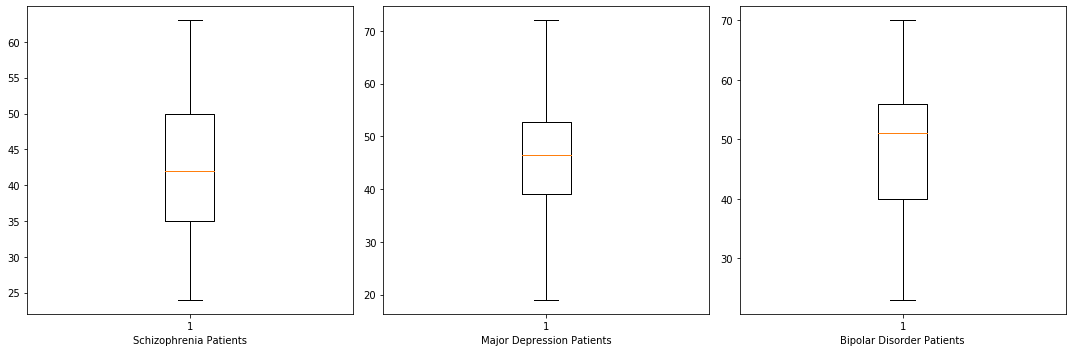

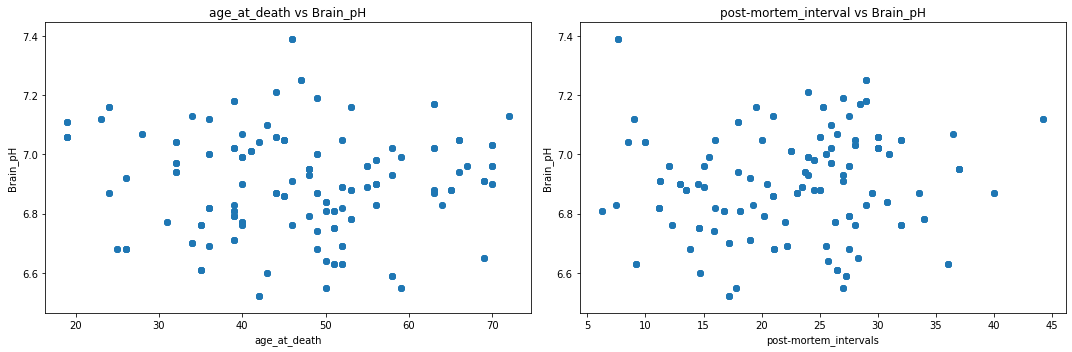

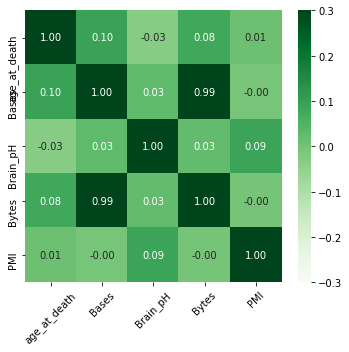

In [58]:
fig, ax = plt.subplots(1,3, figsize=(15,5),tight_layout=True)

all_scz = sra_data.loc[sra_data['clinical_diagnosis'] == 'Schizophrenia']
all_mdd = sra_data.loc[sra_data['clinical_diagnosis'] == 'Major Depression']
all_bpd = sra_data.loc[sra_data['clinical_diagnosis'] == 'Bipolar Disorder']
all_ctl = sra_data.loc[sra_data['clinical_diagnosis'] == 'Control']


ax[0].boxplot(all_scz['age_at_death'])
ax[1].boxplot(all_mdd['age_at_death'])
ax[2].boxplot(all_bpd['age_at_death'])

ax[0].set_xlabel("Schizophrenia Patients")
ax[1].set_xlabel("Major Depression Patients")
tst = ax[2].set_xlabel("Bipolar Disorder Patients")

# Scatter Plots 
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)

x_val_1 = sra_data['age_at_death']
y_val_1 = sra_data['Brain_pH']
ax[0].scatter(x_val_1, y_val_1)

x_val_2 = sra_data['post-mortem_interval']
y_val_2 = sra_data['Brain_pH']
ax[1].scatter(x_val_2, y_val_2)

ax[0].set_title("age_at_death vs Brain_pH")
ax[1].set_title("post-mortem_interval vs Brain_pH")

ax[0].set_xlabel("age_at_death")
ax[1].set_xlabel("post-mortem_intervals")

ax[0].set_ylabel("Brain_pH")
x = ax[1].set_ylabel("Brain_pH")

fig, ax = plt.subplots(1,1, figsize=(5,5),tight_layout=True)


corr_data = sra_data.corr()
corr_data = corr_data.rename({"post-mortem_interval" : "PMI"}, axis=0)
corr_data = corr_data.rename({"post-mortem_interval" : "PMI"}, axis=1)
sns.heatmap(corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


Figure 15 (Top): A visualization of the distribution of age in which patients have passed away for each of the three brain disorders. The mean age at death for schizophrenia patients was 42.6 years old, while the mean age at death for patients diagnosed with major depressive disorder was 44.8 years old. For bipolar disorder patients, the mean age at death was 49.0 years old.

Figure 16 (Middle): In an attempt to show correlation in our data, we plotted data points in two separate scatter plots. One contained points from the variables "age_at_death" and "Brain_pH" (Left). The other contained points for the variables "post-mortem_interval" and "Brain_pH" (Right). We were specifically looking if any correlation existed between the two variables and "Brain_pH." Our findings show a little to no correlation between the aforementioned varibles. 

Figure 17 (Bottom): A heatmap visualization quantifying our results found in Figure 16. The darker the shade and the closer the value is to 1.0, the greater the correlation. Looking at intersection between "age_at_death" and "brain_pH" we see a negative value indicating that correlation is minimal and insignificant. The intersection of port-mortm_interval (labeled as "PMI") and "brain_pH" also shows a low correlation value as well.

#### Sex & Ethnicity: Males

#### Age at Death and Brain_pH Histogram - Male Patients

In terms of the general patient population, looking into the frequencies of the age at death and the brain pH levels gave us a basic insight into our data. However as we continued to perfom EDA, the concerns about the some of the limitations of the project came to fruition. In particular, the biased representation across male and female samples in the data. With the data being so heavily represented by mails, its not suprising that analyzing the frequences of the same variables resulted in almost similar histograms as the ones generated from the general patient population.

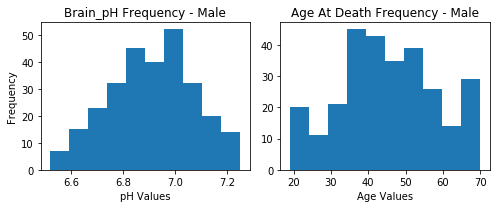

In [60]:
np.warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1,2, figsize=(7,3),tight_layout=True)

ax[0].hist(sra_male['Brain_pH'])
ax[1].hist(sra_male["age_at_death"])

ax[0].title.set_text("Brain_pH Frequency - Male")
ax[1].title.set_text("Age At Death Frequency - Male")

ax[0].set_xlabel("pH Values")
ax[1].set_xlabel("Age Values")

ax[0].set_ylabel("Frequency")
x=ax[0].set_ylabel("Frequency")

Figure 18: (Left) Histogram of brain_pH frequencies from the male patient population of the data. Mean brain_pH from our data was 6.87. (Right) Histogram of age_at_death frequences from the male patient population of the data. Mean age at death from our data was 45.4 years old. The mean values closely resemble those of the general population which should not be suprising when a majority of the overall data (80.3%) is male while the rest being female female (19.6%)

#### Brain Region - Nucleus Accumbens (nAcc)

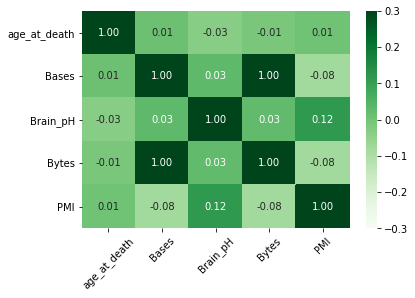

In [69]:
#nAcc
nAcc_region = sra_data[sra_data['source_name'].str.contains("nAcc")]
nAcc_corr_data = nAcc_region.corr()
nAcc_corr_data = nAcc_corr_data.rename({"post-mortem_interval" : "PMI"}, axis=0)
nAcc_corr_data = nAcc_corr_data.rename({"post-mortem_interval" : "PMI"}, axis=1)
sns.heatmap(nAcc_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

Figure 19: This a continuation of the EDA performed on the three different brain regions in terms of their level of correlation. To create this visualization, a dataframe that consisted of only the nucleus accumbens (nAcc) brain region was used.  The darker the shade of green and closer the values are to 1.0, the greater the correlation. Correlation matrix for the nAcc is shown above and does not show any significant correlation between the variables.

#### Brain Region - Dorsolateral Prefrontal Cortex (DLPFC)

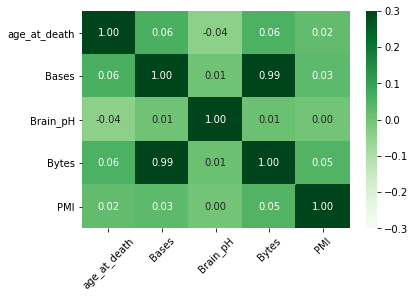

In [68]:
DLPFC_region = sra_data[sra_data['source_name'].str.contains("DLPFC")]
DLPFC_corr_data = DLPFC_region.corr()
DLPFC_corr_data = DLPFC_corr_data.rename({"post-mortem_interval" : "PMI"}, axis=0)
DLPFC_corr_data = DLPFC_corr_data.rename({"post-mortem_interval" : "PMI"}, axis=1)
sns.heatmap(DLPFC_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

Figure 20: This the third correlation matrice that we created as part of our EDA performed on the three different brain regions in terms of their level of correlation. To create this visualization we used a dataframe that consisted of only the dorsolateral prefrontal cortex (DLPFC). The darker the shade of green and closer the values are to 1.0, the greater the correlation. Our observations for DLPFC also show no significant levels of correlations between the variables.

## References

[1]
<span id="fn1">
Ryne C. Ramaker, Kevin M. Bowling, Brittany N. Lasseigne, Megan H. Hagenauer, Andrew A. Hardigan, Nicholas S. Davis, Jason Gertz, Preston M. Cartagena, David M. Walsh, Marquis P. Vawter, Edward G. Jones, Alan F. Schatzberg, Jack D. Barchas, Stanley J. Watson, Blynn G. Bunney, Huda Akil, William E. Bunney, Jun Z. Li, Sara J. Cooper, and Richard M. Myers. Post-mortem molecular profiling of three psychiatric disorders. Genome Medicine, 9(1):72, July 2017. URL: https://doi.org/10.1186/s13073-017-0458-5, doi:10.1186/s13073-017-0458-5. 
</span>

[2] 
<span id="fn2">
NIMH » Schizophrenia. URL: https://www.nimh.nih.gov/health/topics/schizophrenia/index.shtml.
</span>

[3] 
<span id="fn3">
NIMH » Bipolar Disorder. URL: https://www.nimh.nih.gov/health/topics/bipolar-disorder/index.shtml.
</span>

[4] 
<span id="fn4">
NIMH » Depression. URL: 
https://www.nimh.nih.gov/health/topics/depression/index.shtml.
</span>

[5]
<span id="fn5">
Zhong Wang, Mark Gerstein, and Michael Snyder. RNA-Seq URL: a revolutionary tool for transcriptomics \textbar Nature Reviews Genetics. Nature Reviews Genetics, January 2009. URL: https://www.nature.com/articles/nrg2484.
</span>

[6]
<span id="fn6">
Martin, Marcel Bioinformatics in Action (2011) URL: http://journal.embnet.org/index.php/embnetjournal/article/view/200/479
</span>

[7]
<span id="fn7">
Andrews, S. Babraham Bioinformatics URL: https://www.bioinformatics.babraham.ac.uk/projects/fastqc/ 
</span>

[8]
<span id="fn8">
PCA Explanation URL: https://www.originlab.com/doc/Origin-Help/PrincipleComp-Analysis#:~:text=Principal%20Component%20Analysis%20(PCA)%20is,as%20a%20dimensionality%2Dreduction%20technique.
</span>

[9]
<span id="fn9">
LRT, URL: http://evomics.org/resources/likelihood-ratio-test/
</span>

[10]
<span id="fn10">
Heatmap, URL: https://chartio.com/learn/charts/heatmap-complete-guide/ 
</span>

[11]
<span id="fn11">
VST URL: https://en.wikipedia.org/wiki/Variance-stabilizing_transformation
</span>

[12]
<span id="fn12">
Understanding Normalization, URL:https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff#:~:text=Similarly%2C%20the%20goal%20of%20normalization,in%20the%20ranges%20of%20values.&text=So%20we%20normalize%20the%20data,variables%20to%20the%20same%20range.
</span>

[13]
<span id="fn13">
Diana Kwon, Are Some Psychiatric Disorders a pH Problem? URL: https://www.scientificamerican.com/article/are-some-psychiatric-disorders-a-ph-problem/
</span>

[14]
<span id="fn14">
Pandas - Merge Function URL: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
</span>

[15]
<span id="fn15">
DESeq2: Love et al. Genome Biology (2014) URL: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8
</span>